import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
### Libraries

In [2]:
import pyforest

In [10]:
from math import sqrt
from xgboost import XGBRegressor
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from yellowbrick.model_selection import cv_scores

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
from feature_engine import variable_transformers as vt
from feature_engine.discretisers import EqualFrequencyDiscretiser
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder
from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

### Data

#### Reading Data

In [255]:
df = pd.read_excel('final.xlsx')

<IPython.core.display.Javascript object>

In [256]:
df["Month_Year"] = df['Year'].apply(str).str.cat(df['Month'], sep ="_") 

#### Adding DateTime

In [257]:
date = pd.period_range('2019-01', periods=17, freq='M')
date

<IPython.core.display.Javascript object>

PeriodIndex(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05'],
            dtype='period[M]', freq='M')

In [258]:
df['Month_Year'].value_counts()

2019_Jan    583
2019_Jul    456
2019_Sep    449
2019_Mar    445
2019_Nov    444
2019_Dec    434
2019_Oct    432
2019_Apr    428
2019_Aug    418
2019_May    401
2019_Feb    396
2019_Jun    387
2020_Mar    371
2020_Feb    360
2020_Jan    358
2020_Apr    347
2020_May    316
Name: Month_Year, dtype: int64

In [259]:
seq = [583, 396, 445, 428, 401, 387, 456, 418, 449, 432, 444, 434, 358, 360, 371, 347, 316]

In [260]:
df['Final_Date'] = [item for item, count in zip(date, seq) for i in range(count)]
df = df.set_index('Final_Date') 

#### Creatig More Feature

Average Spend per month for respectice columns

In [261]:
df['Avg_pr_M'] = df.groupby('Final_Date')['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Tower'] = df.groupby(['Final_Date', 'Tower'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Category'] = df.groupby(['Final_Date', 'Category'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Country'] = df.groupby(['Final_Date', 'Country'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Region'] = df.groupby(['Final_Date', 'Region'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Vendor'] = df.groupby(['Final_Date', 'Supplier Name'])['Spend'].transform(lambda x : x.mean())

Finding the scaled value by dividing Total Average per month by average per month for the classes of a feature/column

In [262]:
df['Scaled_Tower'] = df['Avg_pr_M_pr_Tower']/df['Avg_pr_M']
df['Scaled_Catagory'] = df['Avg_pr_M_pr_Category']/df['Avg_pr_M']
df['Scaled_Country'] = df['Avg_pr_M_pr_Country']/df['Avg_pr_M']
df['Scaled_Region'] = df['Avg_pr_M_pr_Region']/df['Avg_pr_M']
df['Scaled_Vendor'] = df['Avg_pr_M_pr_Vendor']/df['Avg_pr_M']

#### Dropping few columns

In [263]:
df.drop(['Year','Month','Month_Year','Scaled_Catagory','Scaled_Region',
         'Scaled_Vendor','Supplier Name'], inplace=True,axis=1)

In [264]:
df.head()

Region Country    Tower  \
Final_Date                              
2019-01         APAC   China      R&D   
2019-01         APAC   India       IT   
2019-01     Americas     USA       IT   
2019-01         APAC   China  TechOps   
2019-01         APAC   China  TechOps   

                                               Category          Spend  \
Final_Date                                                               
2019-01         Laboratory Equipment Services and Parts  964537.590650   
2019-01                                     IT Hardware    1609.153631   
2019-01                                     IT Hardware    1210.518148   
2019-01     Maintenance Repair Operation (MRO) Services  158519.945582   
2019-01       MRO Components / Integrator / Distributor   17389.145339   

                 Avg_pr_M  Avg_pr_M_pr_Tower  Avg_pr_M_pr_Category  \
Final_Date                                                           
2019-01     109290.666602       76869.416233         119281.653576   
2019-01     109290.666602       38833.989011           1886.232363   
2019-01     109290.666602       38833.989011           1886.232363   
2019-01     109290.666602      165618.041715          82273.225450   
2019-01     109290.666602      165618.041715          99737.398071   

            Avg_pr_M_pr_Country  Avg_pr_M_pr_Region  Avg_pr_M_pr_Vendor  \
Final_Date                                                                
2019-01           121275.831388       113822.506881       964537.590650   
2019-01            34003.078873       113822.506881         1409.835890   
2019-01           117454.202293       121915.769437         1409.835890   
2019-01           121275.831388       113822.506881        87954.545461   
2019-01           121275.831388       113822.506881        87954.545461   

            Scaled_Tower  Scaled_Country  
Final_Date                                
2019-01         0.703348        1.109663  
2019-01         0.355328        0.311125  
2019-01         0.355328        1.074696  
2019-01         1.515391        1.109663  
2019-01         1.515391        1.109663

### EDA

#### To Study if Time Series Analysis Is Possible

##### Tower

y_axis = average value of spending per month for each catagorie of Tower

x_axis = month (time)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

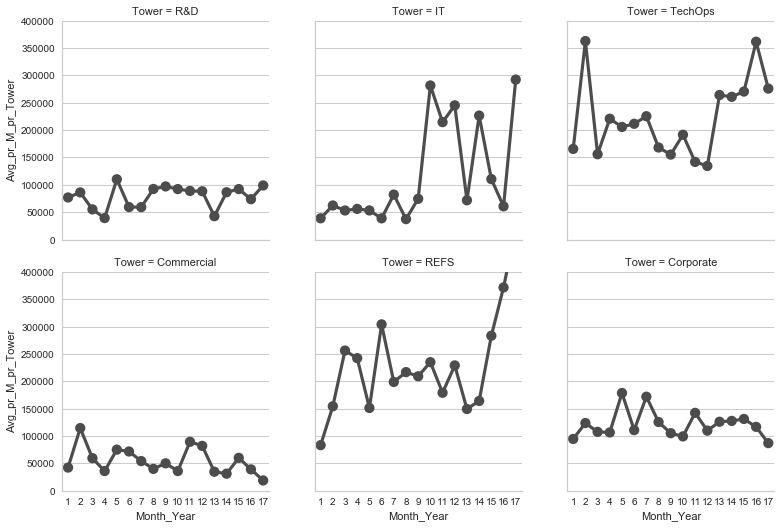

In [224]:
g = sns.FacetGrid(df, col="Tower", col_wrap=3, height=3.75, ylim=(0, 400000))
g = g.map(sns.pointplot, "Month_Year", "Avg_pr_M_pr_Tower", color=".3")
g.set_xticklabels(labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

##### Region
y_axis = average value of spending per month for each catagorie of Tower

x_axis = month (time)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

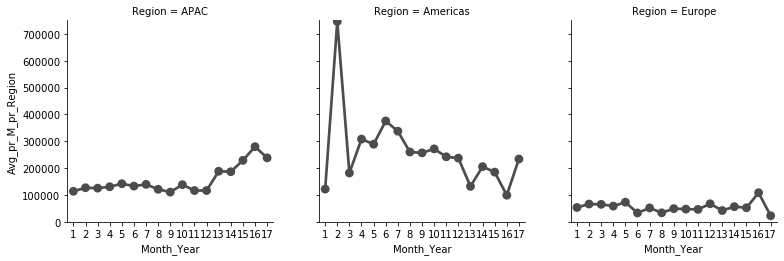

In [387]:
g = sns.FacetGrid(df, col="Region", col_wrap=3, height=3.75, ylim=(0, 750000))
g = g.map(sns.pointplot, "Month_Year", "Avg_pr_M_pr_Region", color=".3")
g.set_xticklabels(labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

##### Catagory

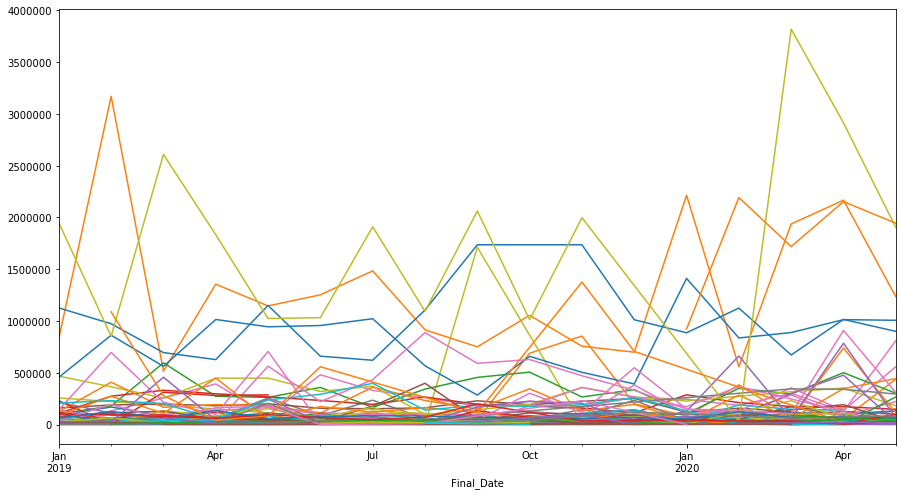

In [462]:
catagories = df.Category.unique()

for catagorie in catagories:
    df1 = df[df['Category'] == catagorie]['Avg_pr_M_pr_Category']
    df_cat0 = df1.groupby('Final_Date').mean()
    df_cat0.plot(figsize=(15,8))

##### Country

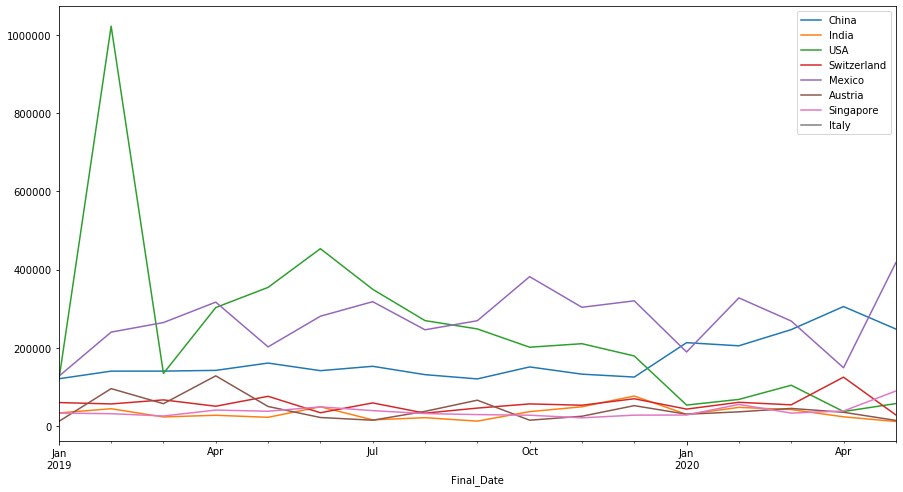

In [460]:
countries = df.Country.unique()

for country in countries:
    df1 = df[df['Country'] == country]['Avg_pr_M_pr_Country']
    df_cat0 = df1.groupby('Final_Date').mean()
    df_cat0.plot(figsize=(15,8)).legend(countries)

##### Conclusion:

From above plots, there are few common insights.
1. No. of data points are only 17 (if we consider average monthly values), which is less for time series
2. Lack of a clear upward/downward trend.
3. Interdependencies of variable which effects spend. These interdepencies will be difficult to capture using timeseries.

#### Understanding the impact of catagorical variable on target

In [599]:
def plot_categories2(df, var):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=90)

    ax2 = ax.twinx()
    ax.bar(df.index, df["perc_data"], color='lightgrey')
    ax2.plot(df.index, df["Spend"], color='green', label='Seconds')
    ax.set_ylabel('percentage of spending per feature')
    ax.set_xlabel(var)
    ax2.set_ylabel('Average spending per feature')
    plt.show()

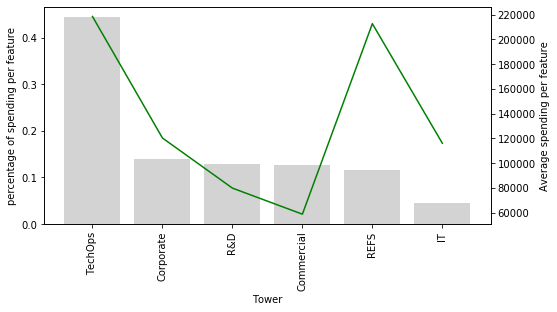

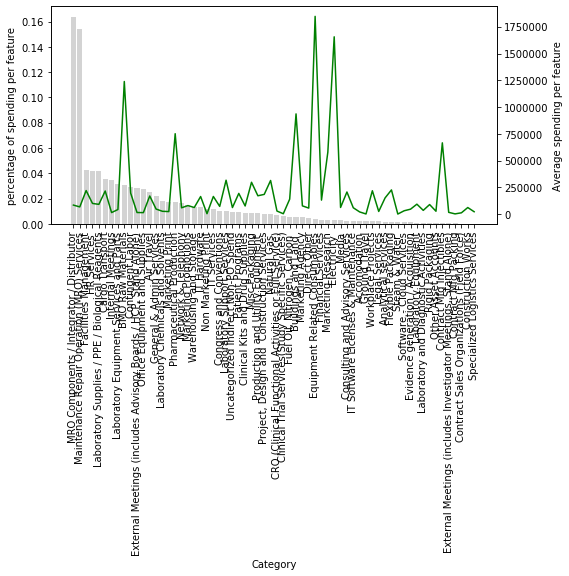

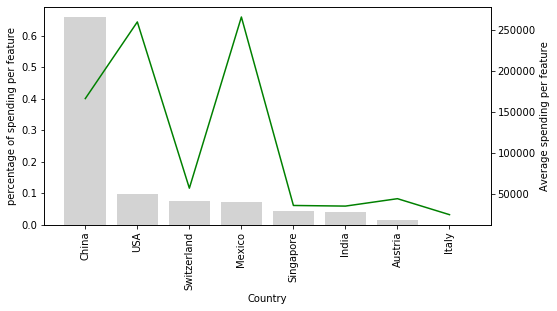

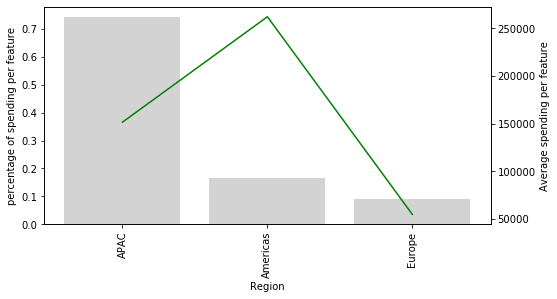

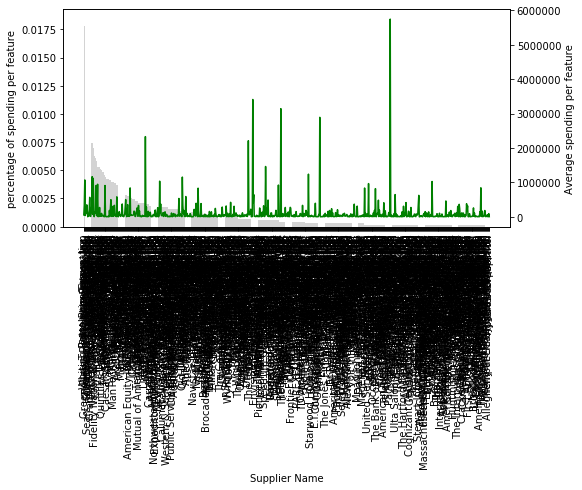

In [600]:
for var in ['Tower','Category','Country','Region','Supplier Name']:
    temp_df = calculate_mean_target_per_category(df, var)
    plot_categories2(temp_df, var)

#### Studying the variables for Machine Learning Model

##### Missing data

In [473]:
df.isnull().sum()

Supplier Name           0
Region                  0
Country                 0
Tower                   0
Category                0
Spend                   0
Avg_pr_M                0
Avg_pr_M_pr_Tower       0
Avg_pr_M_pr_Category    0
Avg_pr_M_pr_Country     0
Avg_pr_M_pr_Region      0
Avg_pr_M_pr_Vendor      0
Scaled_Tower            0
Scaled_Catagory         0
Scaled_Country          0
Scaled_Region           0
Scaled_Vendor           0
dtype: int64

##### Cardinality

High cardinality leads to uneven distribution of categories in train and test sets

In [474]:
obj_df = df.select_dtypes(include=['object']).copy()

for column in obj_df.columns:
    print('Feature: {} has Cardinality Value: {}'. format(column, len(df[column].unique())))
    #print(df[column].unique())
    print()

Feature: Supplier Name has Cardinality Value: 824

Feature: Region has Cardinality Value: 3

Feature: Country has Cardinality Value: 8

Feature: Tower has Cardinality Value: 6

Feature: Category has Cardinality Value: 64



##### Rare Label



Rare values may cause overfitting in tree based algo

###### Initial Study

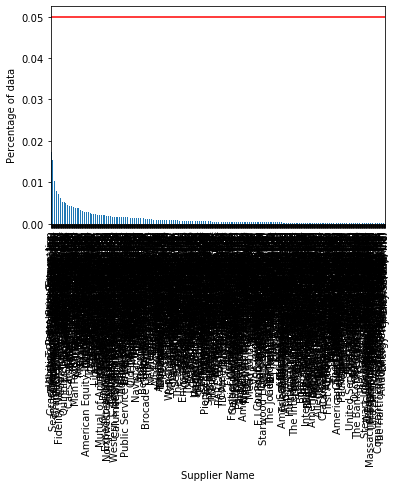

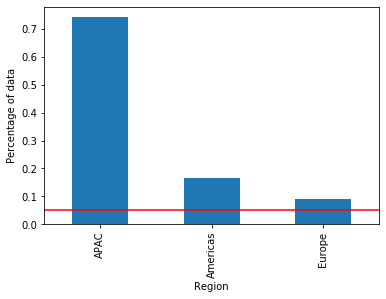

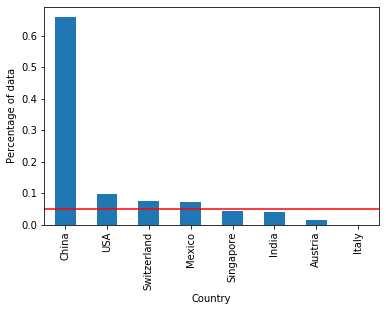

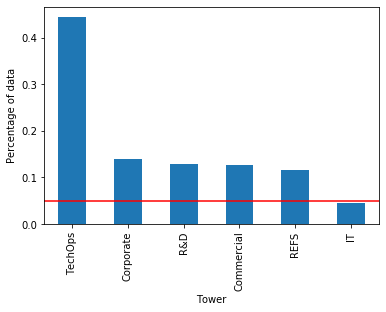

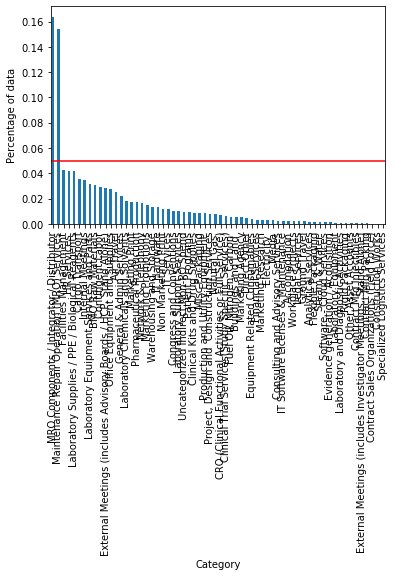

In [475]:
total = len(df)

# for each categorical variable
for col in obj_df:
    temp_df = pd.Series(df[col].value_counts() / total)

    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of data')
    plt.show()

###### Tower

In [44]:
def calculate_mean_target_per_category(df, var):
    total = len(df)
    temp_df = pd.Series(df[var].value_counts() / total).reset_index()
    temp_df.columns = [var, 'perc_data']

    temp_df = temp_df.merge(df.groupby([var])['Spend'].mean().reset_index(),
                            on=var,
                            how='left')
    return temp_df

In [483]:
temp_df = calculate_mean_target_per_category(df, 'Tower')
temp_df

Tower  perc_data          Spend
0     TechOps   0.444128  218415.095122
1   Corporate   0.140214  120215.205952
2         R&D   0.128114   79726.473288
3  Commercial   0.126833   58675.202902
4        REFS   0.115160  212603.532015
5          IT   0.045552  116005.586182

In [484]:
def plot_categories(df, var):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=90)

    ax2 = ax.twinx()
    ax.bar(df.index, df["perc_data"], color='lightgrey')
    ax2.plot(df.index, df["Spend"], color='green', label='Seconds')
    ax.axhline(y=0.05, color='red')
    ax.set_ylabel('percentage of spending per feature')
    ax.set_xlabel(var)
    ax2.set_ylabel('Average spending per feature')
    plt.show()

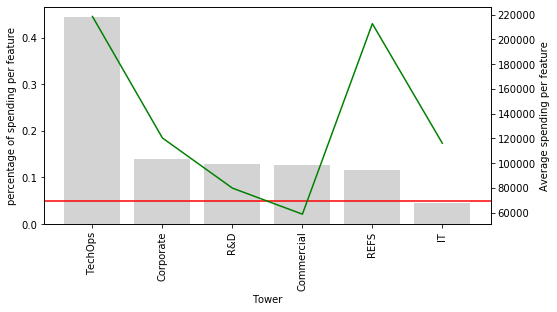

In [485]:
plot_categories(temp_df, 'Tower')

###### Catagory

This analysis is important because the catagories which are rare has higher spending, that means that they are important but we don't have enough data so that model will learn it properly.

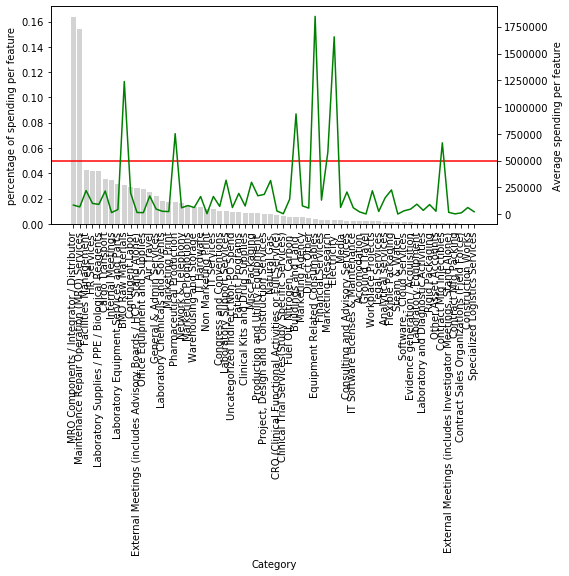

In [486]:
temp_df = calculate_mean_target_per_category(df, 'Category')
plot_categories(temp_df, 'Category')

###### Country

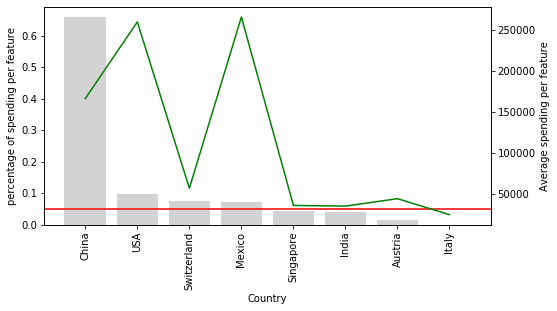

In [487]:
temp_df = calculate_mean_target_per_category(df, 'Country')
plot_categories(temp_df, 'Country')

###### Supplier Name

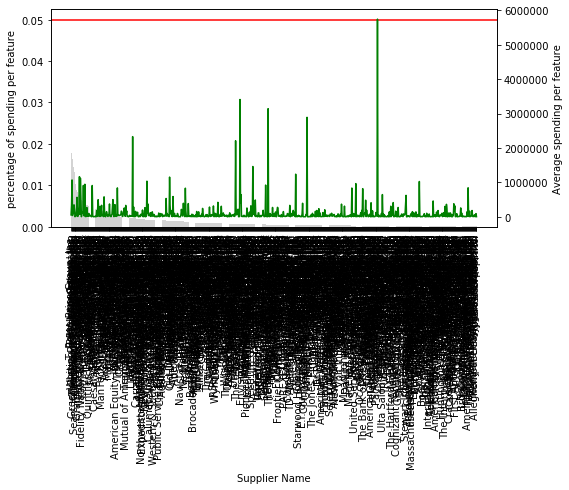

In [488]:
temp_df = calculate_mean_target_per_category(df, 'Supplier Name')
plot_categories(temp_df, 'Supplier Name')

##### Linear Relationship



In this section we are study the linear relationship of target with other features which were created. Our conclusion from this is even after variable log transformation, linear relationship is not good. 

###### linear plot

<IPython.core.display.Javascript object>

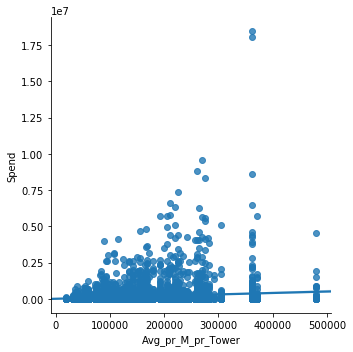

In [490]:
sns.lmplot(x="Avg_pr_M_pr_Tower", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

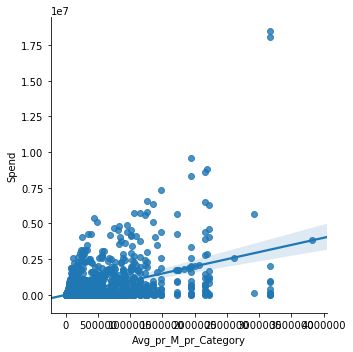

In [491]:
sns.lmplot(x="Avg_pr_M_pr_Category", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

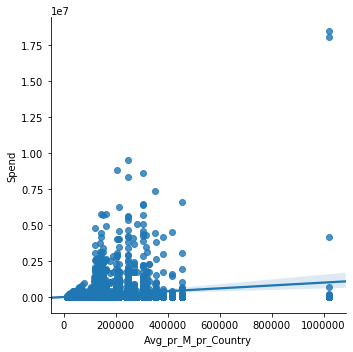

In [492]:
sns.lmplot(x="Avg_pr_M_pr_Country", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

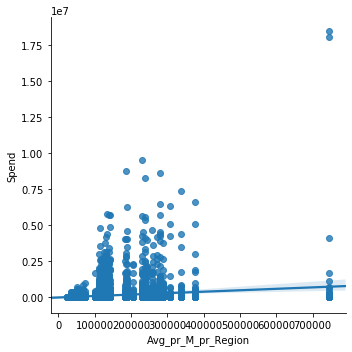

In [493]:
sns.lmplot(x="Avg_pr_M_pr_Region", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

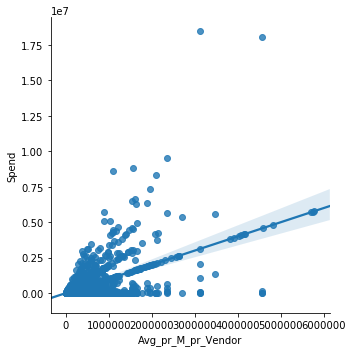

In [494]:
sns.lmplot(x="Avg_pr_M_pr_Vendor", y="Spend", data=df, order=1)

###### Linear plot after log transformation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

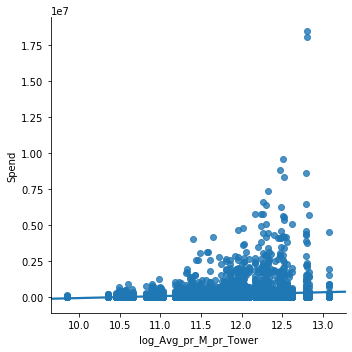

In [501]:
df['log_Avg_pr_M_pr_Tower'] = np.log(df['Avg_pr_M_pr_Tower'])
sns.lmplot(x="log_Avg_pr_M_pr_Tower", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

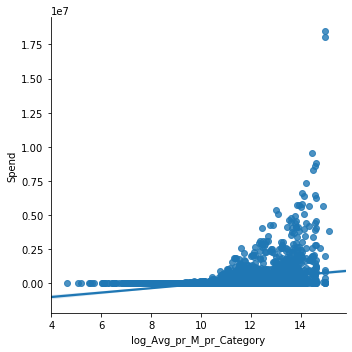

In [502]:
df['log_Avg_pr_M_pr_Category'] = np.log(df['Avg_pr_M_pr_Category'])
sns.lmplot(x="log_Avg_pr_M_pr_Category", y="Spend", data=df, order=1)

###### Correlation Plot

<IPython.core.display.Javascript object>

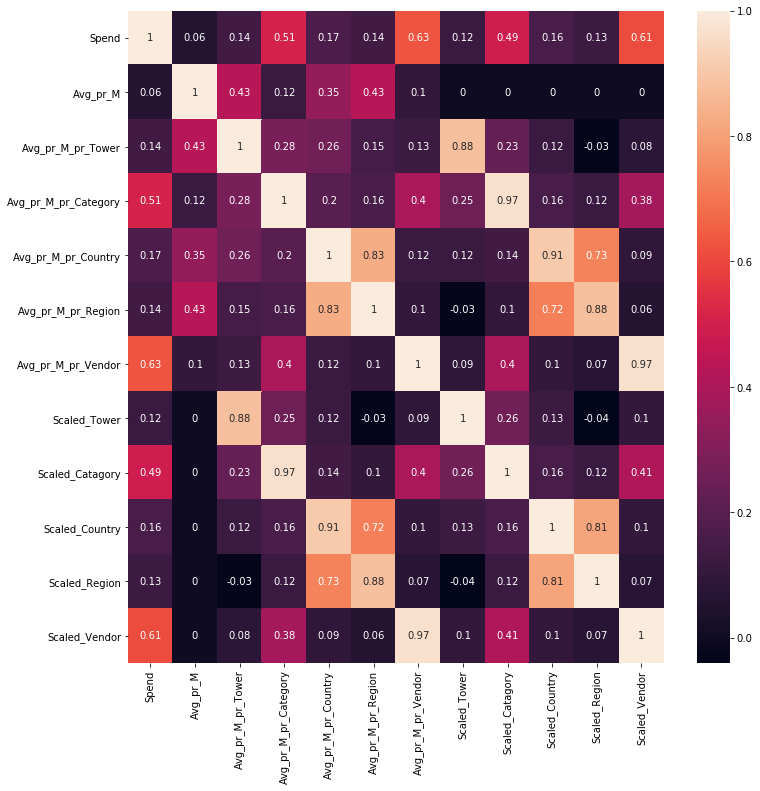

In [495]:
Cont_df = df.select_dtypes(include=['int64', 'float']).copy()

correlation_matrix = Cont_df.corr().round(2)

figure = plt.figure(figsize=(12, 12))
sns.heatmap(data=correlation_matrix, annot=True)

<IPython.core.display.Javascript object>

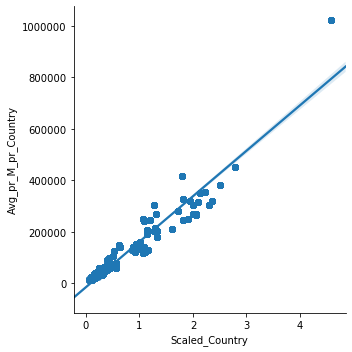

In [500]:
sns.lmplot(x="Scaled_Country", y="Avg_pr_M_pr_Country", data=df, order=1)

<IPython.core.display.Javascript object>

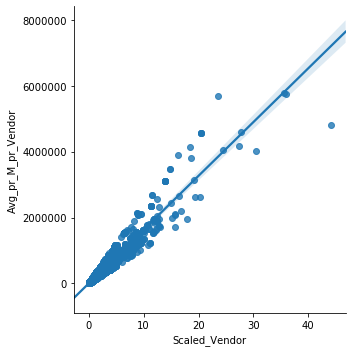

In [499]:
sns.lmplot(x="Scaled_Vendor", y="Avg_pr_M_pr_Vendor", data=df, order=1)

<IPython.core.display.Javascript object>

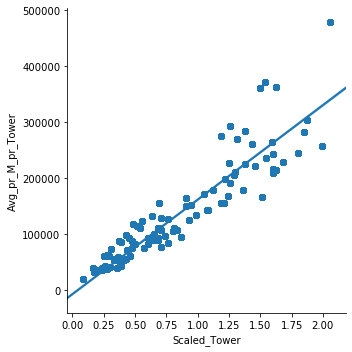

In [497]:
sns.lmplot(x="Scaled_Tower", y="Avg_pr_M_pr_Tower", data=df, order=1)

<IPython.core.display.Javascript object>

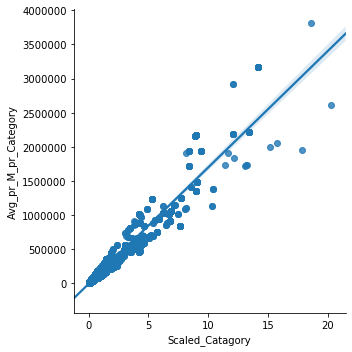

In [498]:
sns.lmplot(x="Scaled_Catagory", y="Avg_pr_M_pr_Category", data=df, order=1)

So our beleif of creating new scaled feature which could be used as additional feature to capture some amount of information can not be used as they have high correlation with their average values. We need to remove them.

##### Outlier

We study the presense of outlier using interquantile proximity rule

###### Plotting Histogram, QQ Plot and Box plot

In [631]:
import scipy.stats as stats

def diagnostic_plots(df, variable):

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

The feature is Avg_pr_M:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

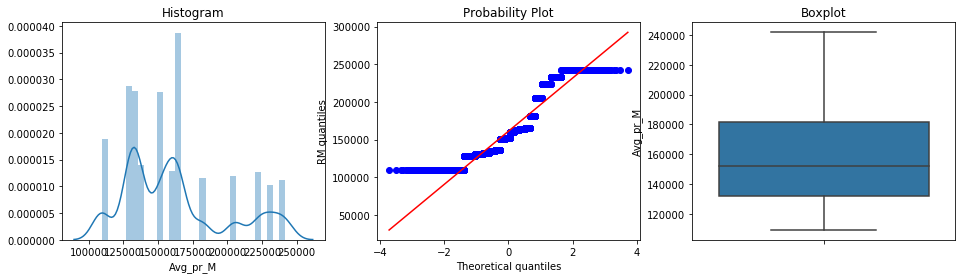

The feature is Avg_pr_M_pr_Tower:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

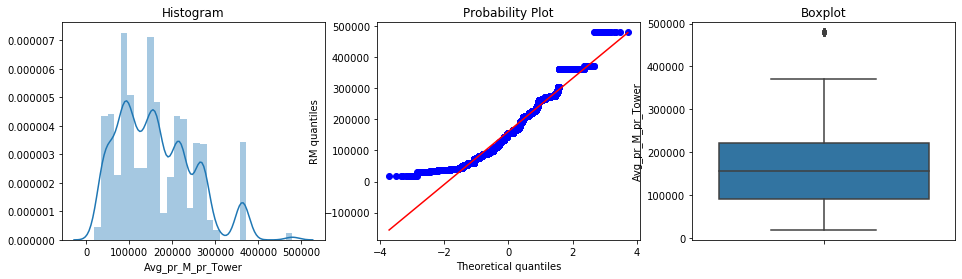

The feature is Avg_pr_M_pr_Category:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

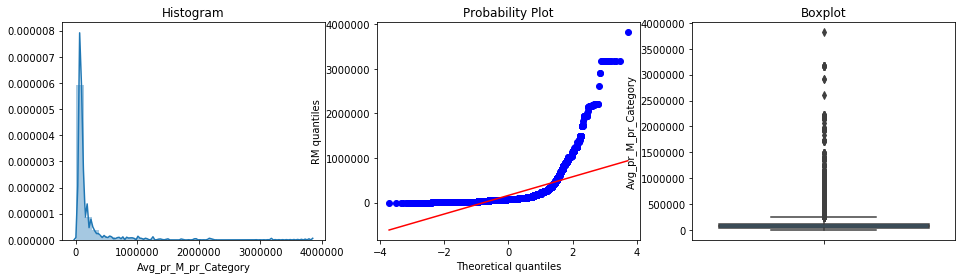

The feature is Avg_pr_M_pr_Country:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

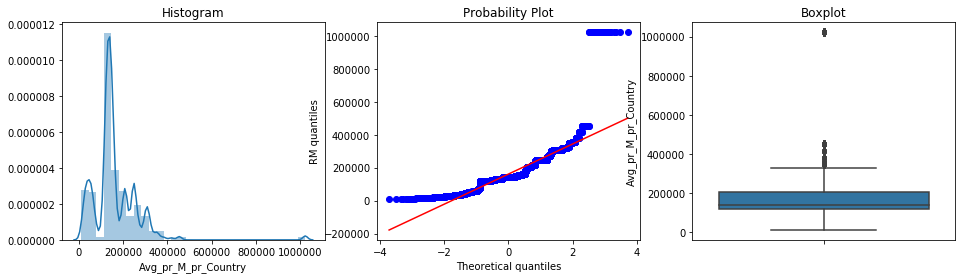

The feature is Avg_pr_M_pr_Region:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

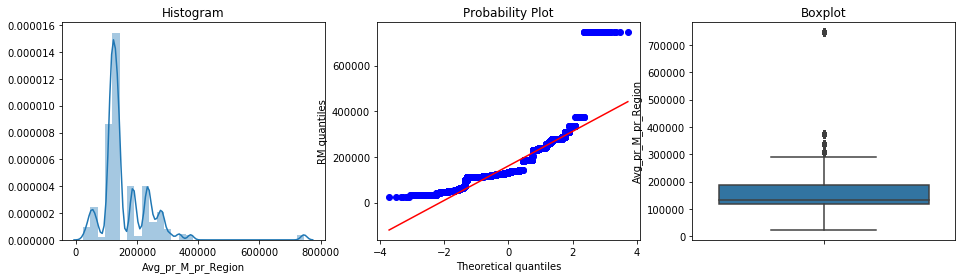

The feature is Avg_pr_M_pr_Vendor:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

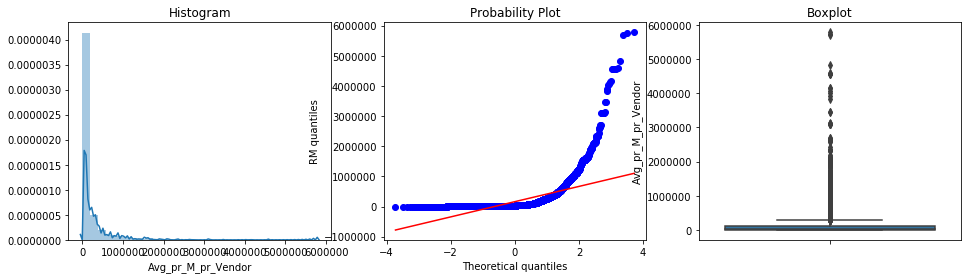

The feature is Spend:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

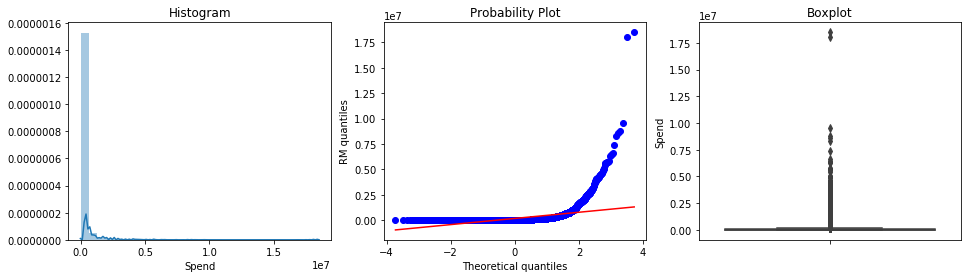

In [510]:
for column in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor', 'Spend']:
    print('The feature is {}:'.format(column))
    diagnostic_plots(df, column)

###### Outlier detection for skewed variables

In [511]:
# function to find upper and lower boundaries
# for skewed distributed variables

def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [530]:
# looking for outliers,
# using the interquantile proximity rule
# IQR * 1.5, the standard metric

print('total data: {}'.format(len(df)))
print()
for feature in ['Avg_pr_M_pr_Category','Avg_pr_M_pr_Vendor','Spend', 'Avg_pr_M_pr_Region','Avg_pr_M_pr_Tower']:
    upper_boundary, lower_boundary = find_skewed_boundaries(df, feature, 1.5)
    print('{}: upper limit & {}: lower limit'.format(upper_boundary, lower_boundary) )
    
    print('data with value bigger than {}: {}'.format(upper_boundary, len(df[df[feature] > upper_boundary])))
    print('% data with value bigger than {}: {}'.format(upper_boundary, len(df[df[feature] > upper_boundary])/len(df)))
    print()                                                                      

total data: 7025

246017.3723207988: upper limit & -76290.58196415287: lower limit
data with value bigger than 246017.3723207988: 943
% data with value bigger than 246017.3723207988: 0.13423487544483986

300707.51928516: upper limit & -168127.20233244: lower limit
data with value bigger than 300707.51928516: 1007
% data with value bigger than 300707.51928516: 0.14334519572953736

179111.98187532002: upper limit & -100340.69640660001: lower limit
data with value bigger than 179111.98187532002: 1042
% data with value bigger than 179111.98187532002: 0.14832740213523132

296109.1579575251: upper limit & 8924.874981761226: lower limit
data with value bigger than 296109.1579575251: 273
% data with value bigger than 296109.1579575251: 0.038861209964412814

413732.07774968795: upper limit & -100695.63139588707: lower limit
data with value bigger than 413732.07774968795: 26
% data with value bigger than 413732.07774968795: 0.003701067615658363



##### Feature Scaling

We are planning to go ahead with tree based algorithm, hence feature scalling is not important.

### Feature Engineering/Preprocessing

#### Variable Transformation

In [535]:
def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

In [546]:
# Transforming Variable

lt1 = vt.BoxCoxTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category','Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])
lt1.fit(df)
data_tf1 = lt1.transform(df)

lt2 = vt.YeoJohnsonTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category','Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])
lt2.fit(df)
data_tf2 = lt2.transform(df)

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\stats\morestats.py:1478: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1987: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1984: RuntimeWarning: inval

Plot for Avg_pr_M


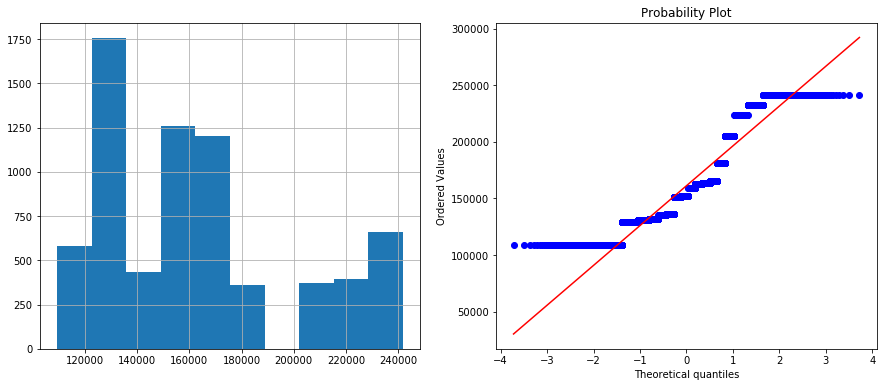

BoxCox Transformed Plot for Avg_pr_M


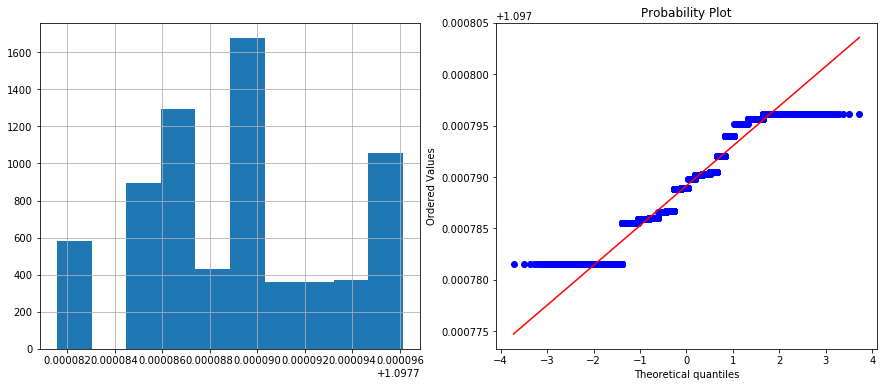

Yeo Johnson Transformed Plot for Avg_pr_M


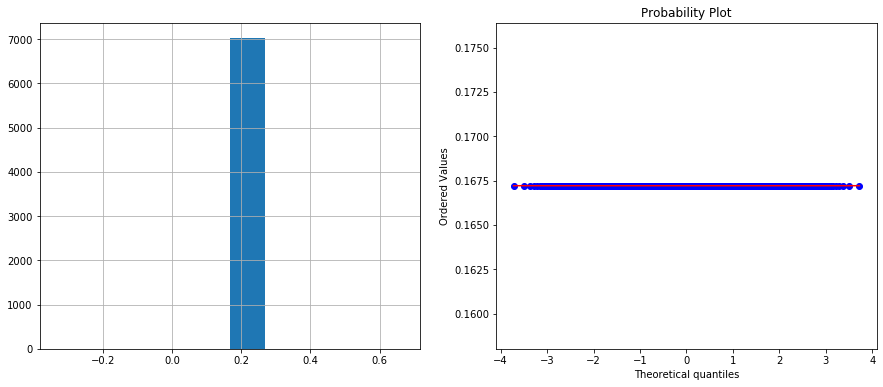

Plot for Avg_pr_M_pr_Tower


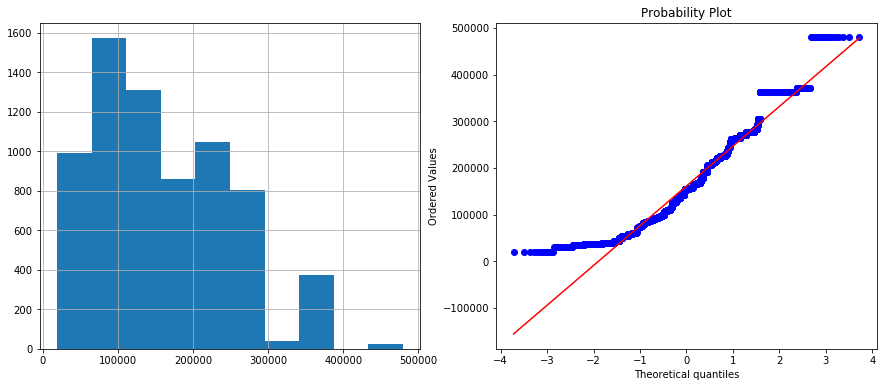

BoxCox Transformed Plot for Avg_pr_M_pr_Tower


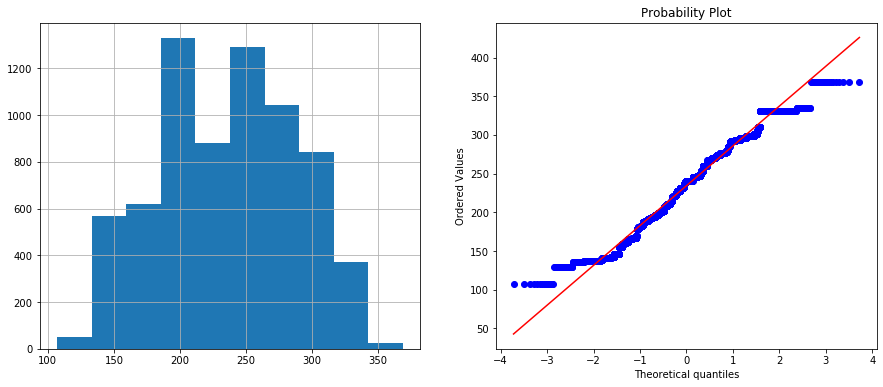

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Tower


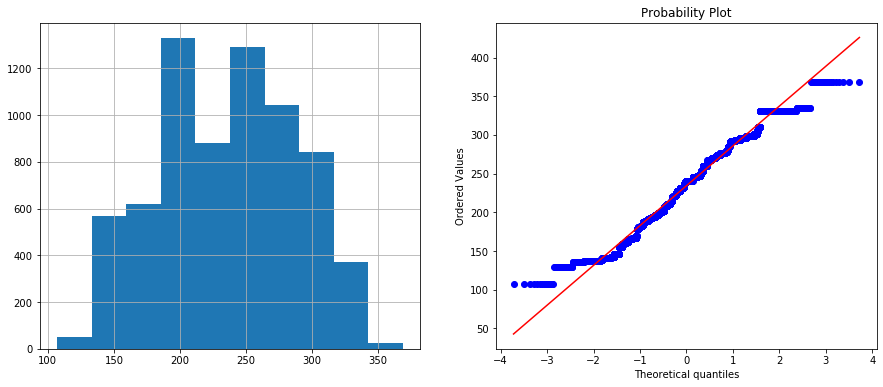

Plot for Avg_pr_M_pr_Category


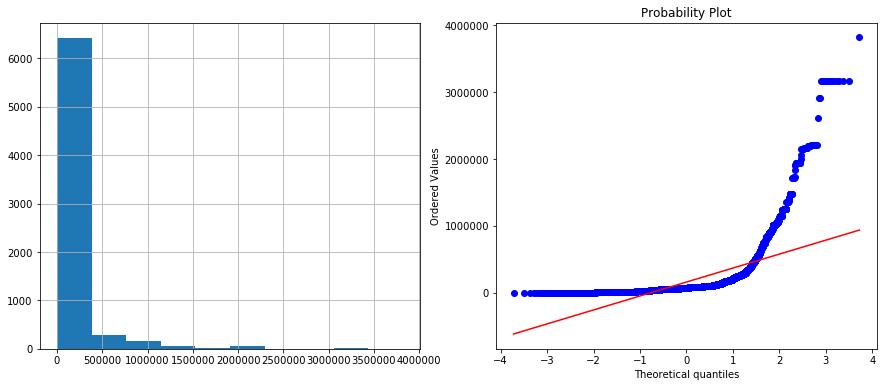

BoxCox Transformed Plot for Avg_pr_M_pr_Category


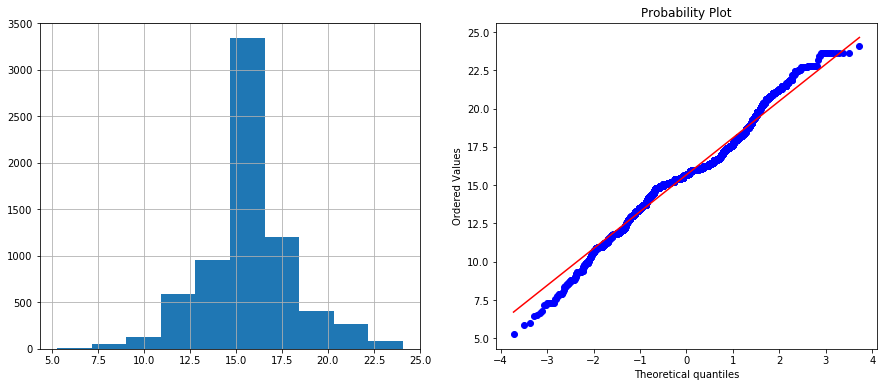

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Category


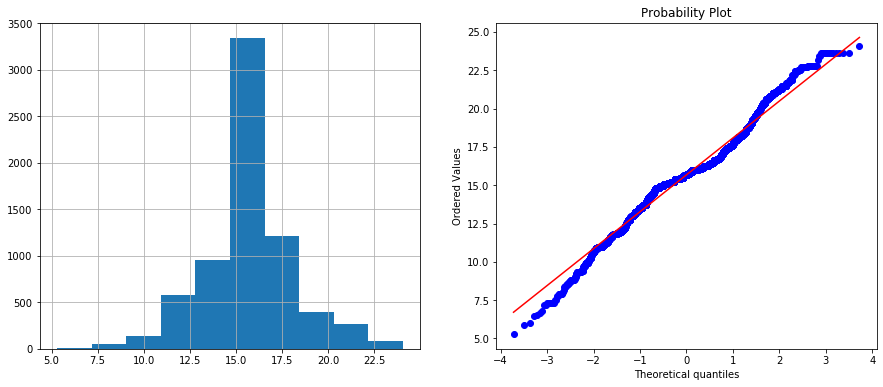

Plot for Avg_pr_M_pr_Country


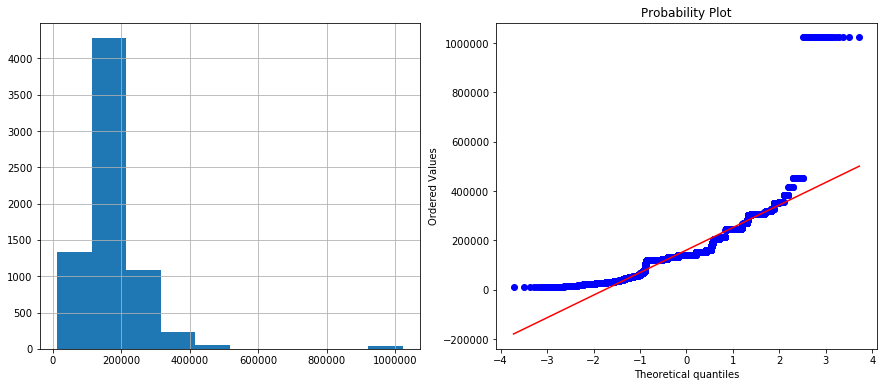

BoxCox Transformed Plot for Avg_pr_M_pr_Country


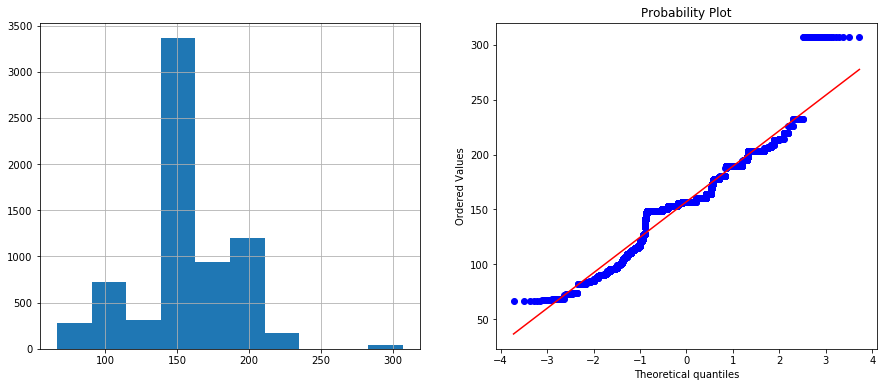

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Country


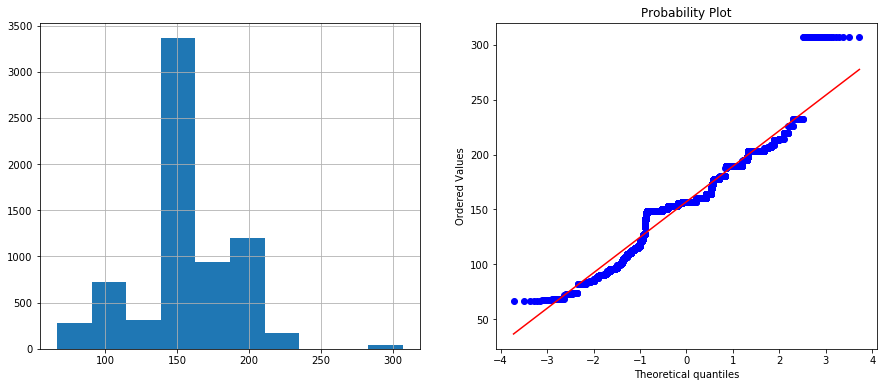

Plot for Avg_pr_M_pr_Region


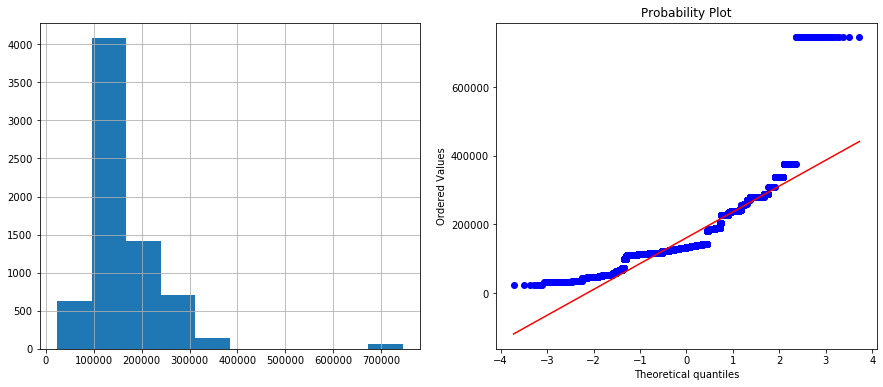

BoxCox Transformed Plot for Avg_pr_M_pr_Region


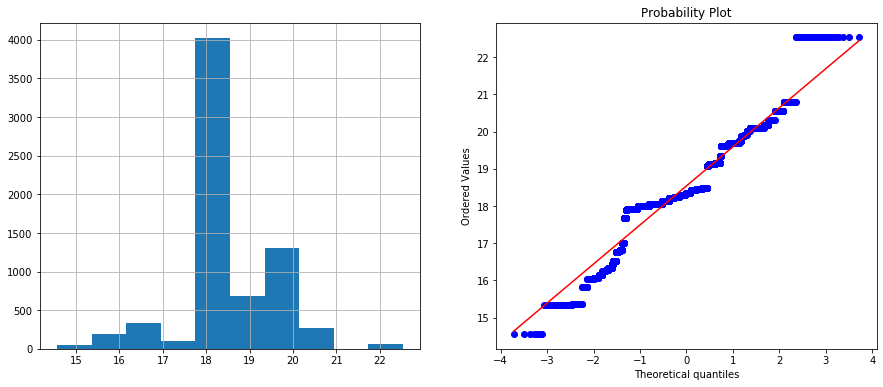

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Region


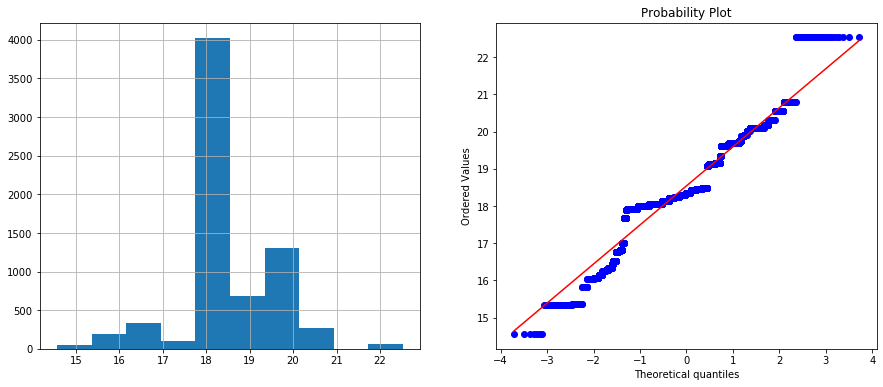

Plot for Avg_pr_M_pr_Vendor


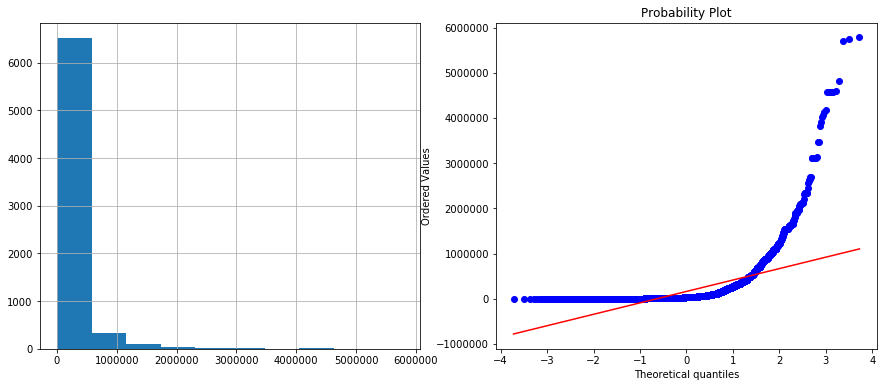

BoxCox Transformed Plot for Avg_pr_M_pr_Vendor


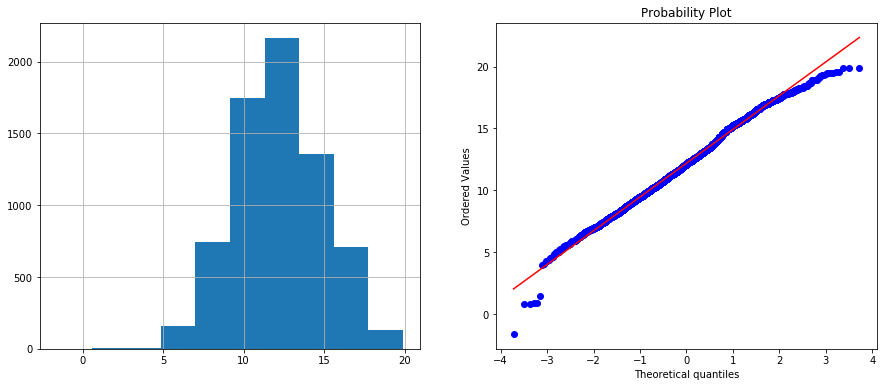

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Vendor


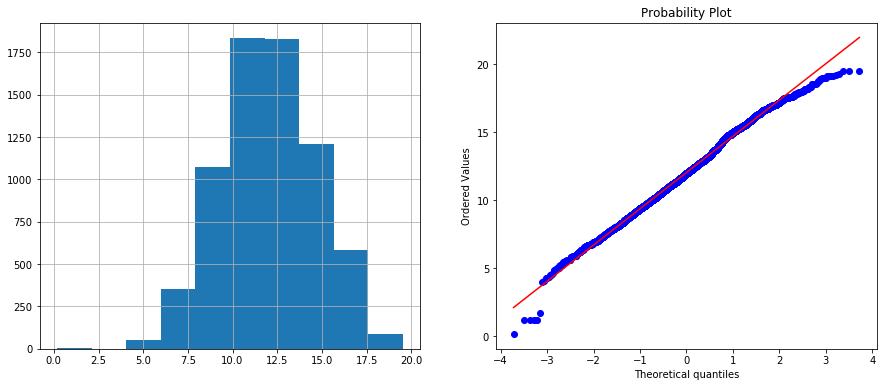

In [550]:
# plotting
for variable in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                 'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor']:
    print('Plot for {}'.format(variable))
    diagnostic_plots(df, variable)
    print('BoxCox Transformed Plot for {}'.format(variable))
    diagnostic_plots(data_tf1, variable)
    print('Yeo Johnson Transformed Plot for {}'.format(variable))
    diagnostic_plots(data_tf2, variable)

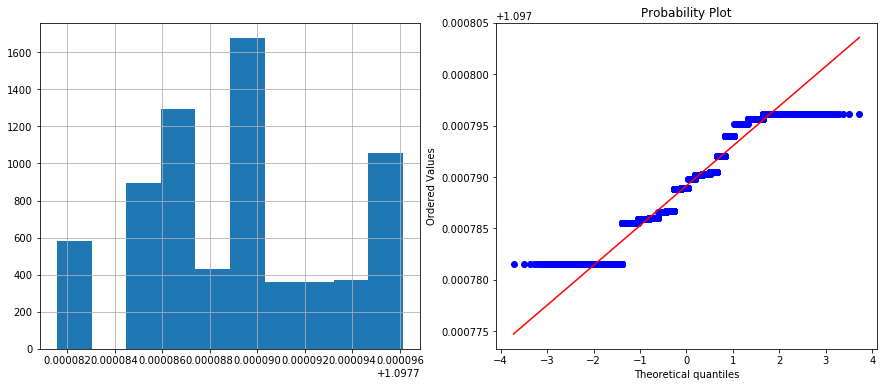

In [543]:
diagnostic_plots(data_tf, 'Avg_pr_M')

#### Discretization

###### Performing Equal Frequency Discretization

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values.

Discretisation helps handle outliers and may improve value spread in skewed variables.

Equal frequency discretisation divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is a Unsupervised discretisation methods.

In [32]:
variable = ['Scaled_Tower','Scaled_Catagory','Scaled_Country', 'Scaled_Region','Scaled_Vendor']

X_train, X_test, y_train, y_test = train_test_split(df[variable], df['Spend'],
                                                    test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((4917, 5), (2108, 5))

In [33]:
disc = EqualFrequencyDiscretiser(q=10, variables=variable, return_object=True)

# find the intervals
disc.fit(X_train)

# transform train and text
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [34]:
train_t.dtypes

Scaled_Tower       object
Scaled_Catagory    object
Scaled_Country     object
Scaled_Region      object
Scaled_Vendor      object
dtype: object

###### Exploring if the bins have a linear relationship with target

Text(0, 0.5, 'mean of Scaled_Tower')

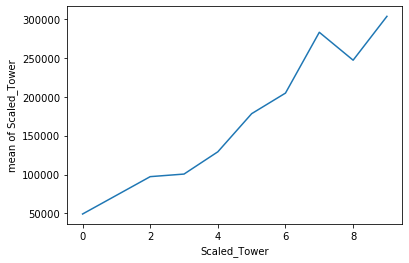

In [580]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Tower')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Tower')

Text(0, 0.5, 'mean of Scaled_Catagory')

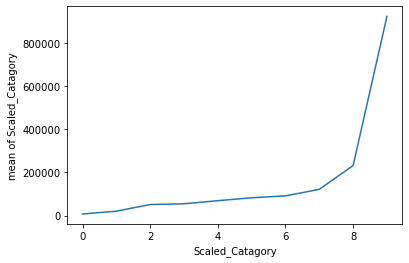

In [581]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Catagory')

Text(0, 0.5, 'mean of Scaled_Country')

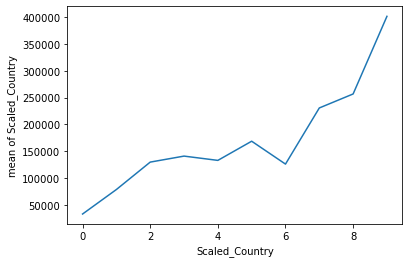

In [582]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Country')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Country')

In [583]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Category')

Text(0, 0.5, 'mean of Scaled_Region')

Text(0, 0.5, 'mean of Scaled_Vendor')

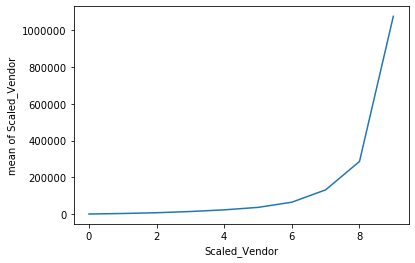

In [584]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Vendor')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Vendor')

The variables don't show a clear linear relationship with target variable after discretization. One way to solve this is by encoding.

###### Ordinal Encoding to establish linear relationship with target

In [35]:
enc = OrdinalCategoricalEncoder(encoding_method = 'ordered')

enc.fit(train_t, y_train)

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

In [588]:
enc.encoder_dict_

{'Scaled_Tower': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 7: 8, 9: 9},
 'Scaled_Catagory': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9},
 'Scaled_Country': {0: 0,
  1: 1,
  6: 2,
  2: 3,
  4: 4,
  3: 5,
  5: 6,
  7: 7,
  8: 8,
  9: 9},
 'Scaled_Region': {0: 0, 3: 1, 1: 2, 4: 3, 2: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9},
 'Scaled_Vendor': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}}

Text(0, 0.5, 'mean of Scaled_Tower')

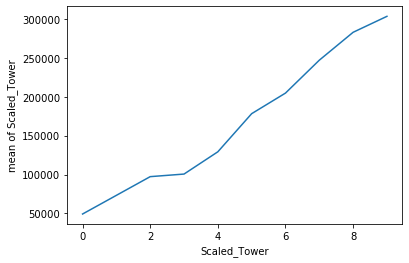

In [589]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Tower')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Tower')

Text(0, 0.5, 'mean of Scaled_Catagory')

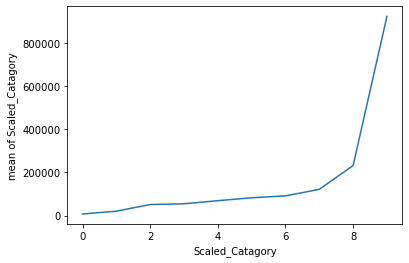

In [590]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Catagory')

Text(0, 0.5, 'mean of Scaled_Country')

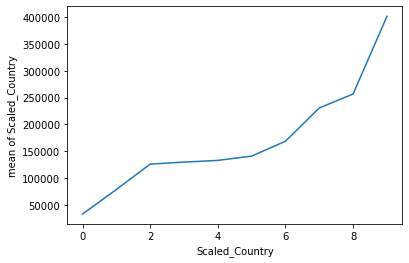

In [591]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Country')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Country')

Text(0, 0.5, 'mean of Scaled_Category')

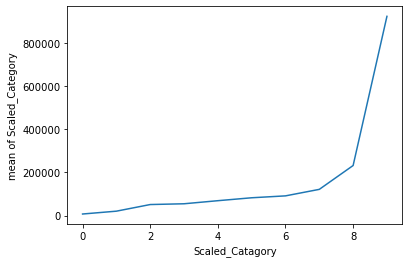

In [592]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Category')

Text(0, 0.5, 'mean of Scaled_Vendor')

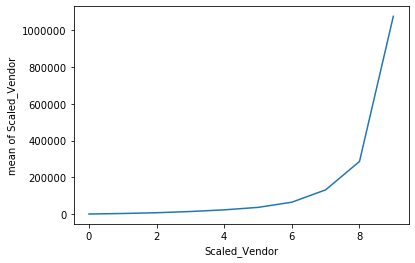

In [593]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Vendor')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Vendor')

###### Conclusion

From above analysis we can say that, even after binning and encoding few of the variables are not having monotonic relationship with target variable. Hece we should remove them. The variable to be used after binning are:
1. Scaled_Country
2. Scaled_Tower

#### Catagorical Variable Encoding & Rare Variable Treatment

##### Rare Label Encoding

###### Rare Label Study

In [39]:
cols = ['Supplier Name', 'Region', 'Country', 'Tower', 'Category']
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Spend'],
                                                    test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((4917, 5), (2108, 5))

In [40]:
for col in cols:
    print(X_train.groupby(col)[col].count() / len(X_train)) # frequency
    print()

Supplier Name
3M Company                      0.002847
A. Schulman, Inc.               0.000407
AAR Corp.                       0.001830
ABM Industries Incorporated     0.002237
AECOM Technology Corporation    0.000203
                                  ...   
Yahoo! Inc.                     0.000203
Zions Bancorporation            0.004271
eBay Inc.                       0.001017
hhgregg, Inc.                   0.000610
salesforce.com, inc.            0.000610
Name: Supplier Name, Length: 733, dtype: float64

Region
APAC        0.738052
Americas    0.171649
Europe      0.090299
Name: Region, dtype: float64

Country
Austria        0.014033
China          0.654464
India          0.039455
Italy          0.000203
Mexico         0.072198
Singapore      0.044133
Switzerland    0.076063
USA            0.099451
Name: Country, dtype: float64

Tower
Commercial    0.129754
Corporate     0.139313
IT            0.045760
R&D           0.127720
REFS          0.114094
TechOps       0.443360
Name: Towe

###### Plotting

<IPython.core.display.Javascript object>

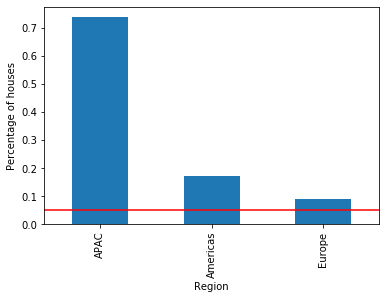

<IPython.core.display.Javascript object>

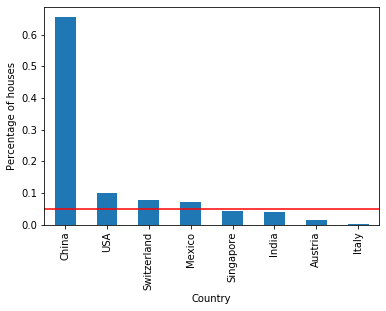

<IPython.core.display.Javascript object>

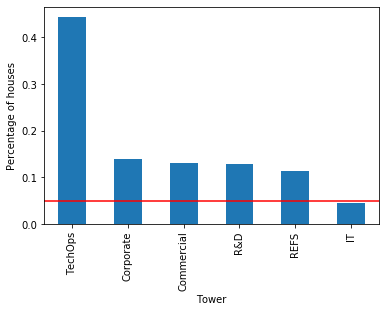

<IPython.core.display.Javascript object>

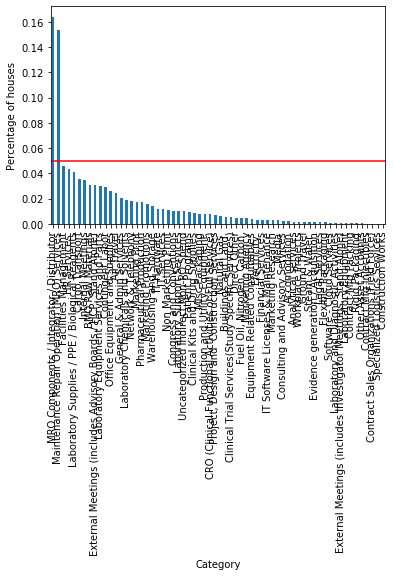

In [41]:
for col in ['Region', 'Country', 'Tower', 'Category']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

###### Re-grouping rare labels with pandas

In [46]:
def find_non_rare_labels(df, variable, tolerance):
    temp = df.groupby([variable])[variable].count() / len(df) 
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    return non_rare

In [47]:
def rare_encoding(X_train, X_test, variable, tolerance):
    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
    X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test

In [48]:
for variable in ['Region', 'Country', 'Tower', 'Category']:
    X_train, X_test = rare_encoding(X_train, X_test, variable, 0.05)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###### Rare Label Using Feature Engine

In [ ]:
rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['Region','Country','Tower','Category'] # variables to re-group
)  

In [ ]:
rare_encoder.fit(X_train.fillna('Missing'))

In [ ]:
X_train = rare_encoder.transform(X_train.fillna('Missing'))
X_test = rare_encoder.transform(X_test.fillna('Missing'))

###### Plotting After Rare Label Encoding

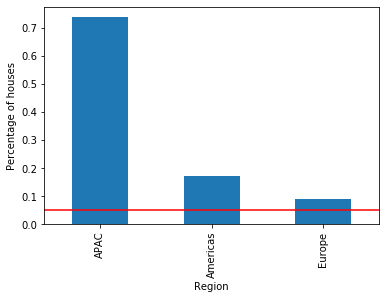

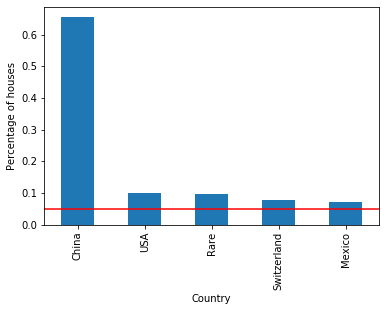

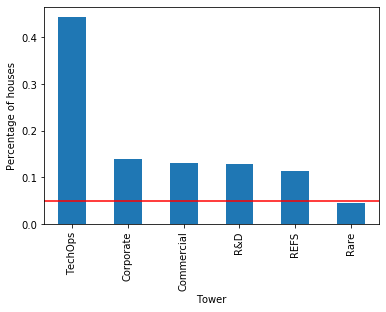

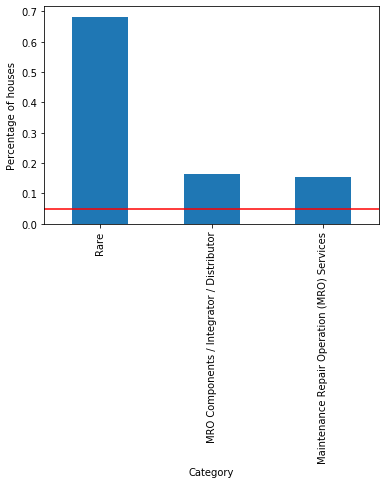

In [614]:
for col in ['Region', 'Country', 'Tower', 'Category']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

##### Catagorical Encoding

Going ahead with Frequency Encoding. Reason for this is, since we are planning for tree based algo, one hot encoding will not work. In addition frequency encoding adds additional information into data. It also doenot increase feature space.

In [626]:
count_enc = CountFrequencyCategoricalEncoder(encoding_method='count',
                                             variables=['Region', 'Country', 
                                                        'Tower', 'Category'])

count_enc.fit(X_train)

CountFrequencyCategoricalEncoder(variables=['Region', 'Country', 'Tower',
                                            'Category'])

In [627]:
count_enc.encoder_dict_

{'Region': {'APAC': 3629, 'Americas': 844, 'Europe': 444},
 'Country': {'China': 3218,
  'USA': 489,
  'Rare': 481,
  'Switzerland': 374,
  'Mexico': 355},
 'Tower': {'TechOps': 2180,
  'Corporate': 685,
  'Commercial': 638,
  'R&D': 628,
  'REFS': 561,
  'Rare': 225},
 'Category': {'Rare': 3356,
  'MRO Components / Integrator / Distributor': 806,
  'Maintenance Repair Operation (MRO) Services': 755}}

In [628]:
X_train = count_enc.transform(X_train)
X_test = count_enc.transform(X_test)

# Looking at the result
X_train.head()

Supplier Name  Region  Country  Tower  Category
Final_Date                                                                
2019-01     The Babcock & Wilcox Company     844      355    685      3356
2019-12              The Hershey Company    3629     3218    628      3356
2019-03               Under Armour, Inc.     844      489    638      3356
2019-07        Arthur J. Gallagher & Co.     844      489    638      3356
2020-01       Stater Bros. Holdings Inc.    3629     3218   2180       755

#### Outlier Treatment

###### Plots after variable transformation

The feature is Avg_pr_M:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

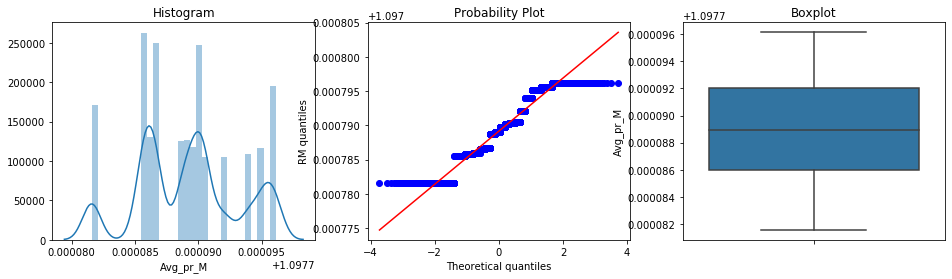

The feature is Avg_pr_M_pr_Tower:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

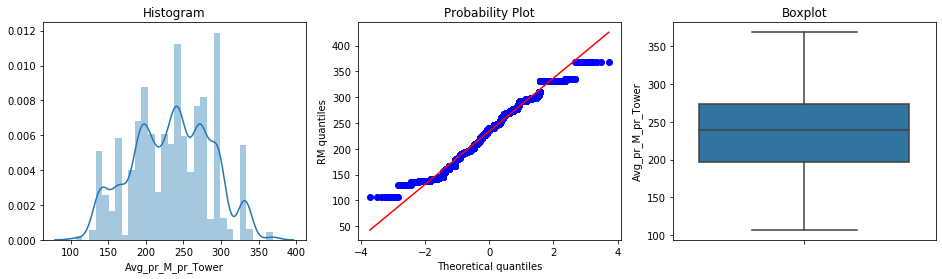

The feature is Avg_pr_M_pr_Category:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

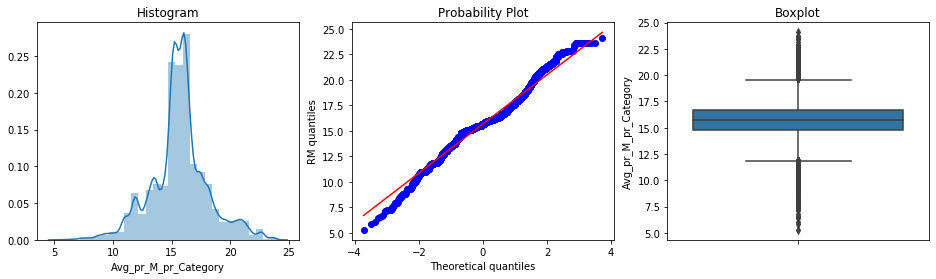

The feature is Avg_pr_M_pr_Country:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

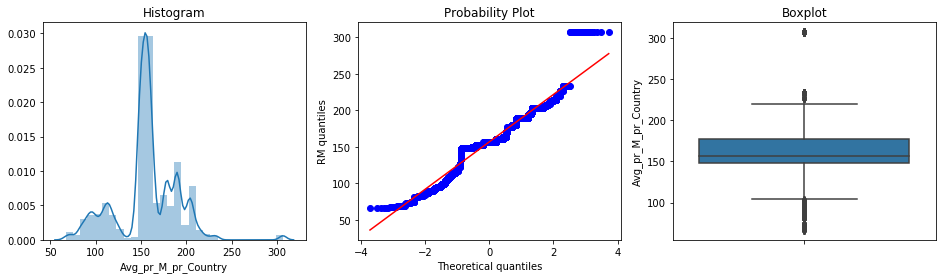

The feature is Avg_pr_M_pr_Region:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

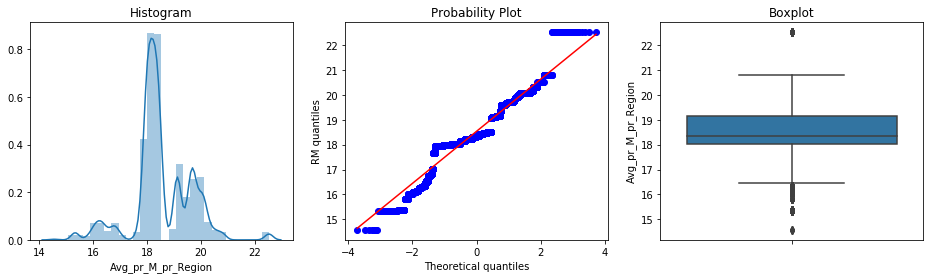

The feature is Avg_pr_M_pr_Vendor:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

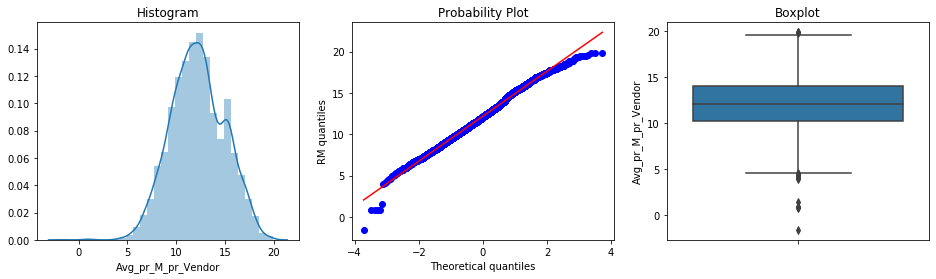

The feature is Spend:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

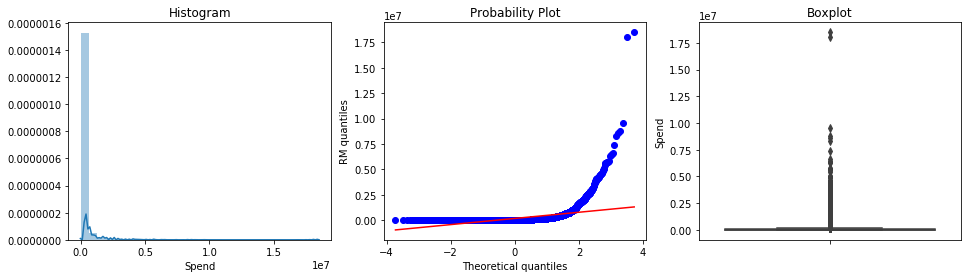

In [632]:
# Running diagonistic plot on transformed variables using box cox transformation i.e. data_tf1 
# from step 1.0.5.1

for column in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor', 'Spend']:
    print('The feature is {}:'.format(column))
    diagnostic_plots(data_tf1, column)

###### Winsorization to Treat Outlier

Winsorization is a way to minimize the influence of outliers in your data by either:
    1. Assigning the outlier a lower weight,
    2. Changing the value so that it is close to other values in the set.

In [634]:
windsoriser = Winsorizer(distribution='skewed', # choose skewed for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                                     'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])

windsoriser.fit(data_tf1)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category',
                      'Avg_pr_M_pr_Country', 'Avg_pr_M_pr_Region',
                      'Avg_pr_M_pr_Vendor'])

In [635]:
data_tf1_ROut = windsoriser.transform(data_tf1)

The feature is Avg_pr_M:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

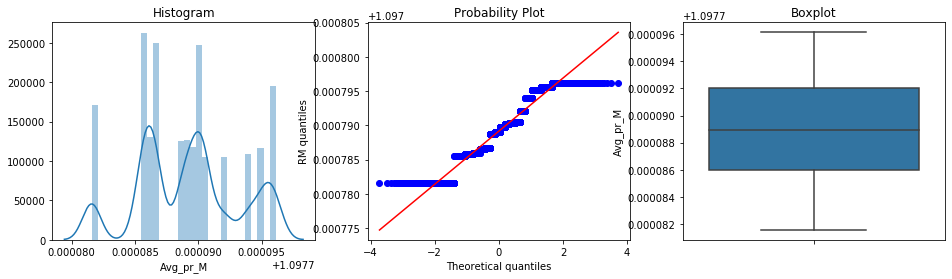

The feature is Avg_pr_M_pr_Tower:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

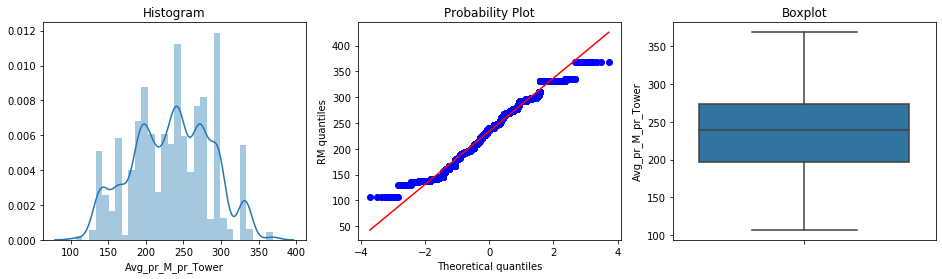

The feature is Avg_pr_M_pr_Category:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

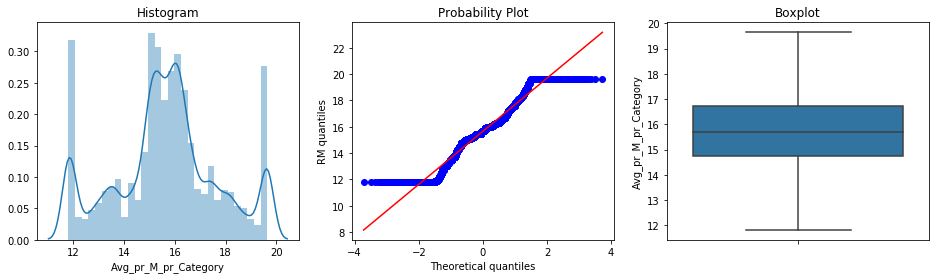

The feature is Avg_pr_M_pr_Country:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

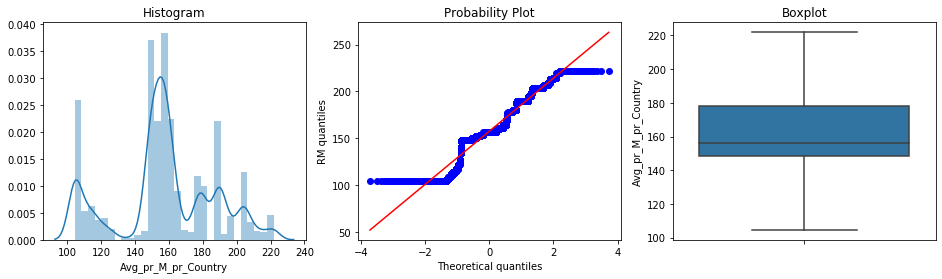

The feature is Avg_pr_M_pr_Region:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

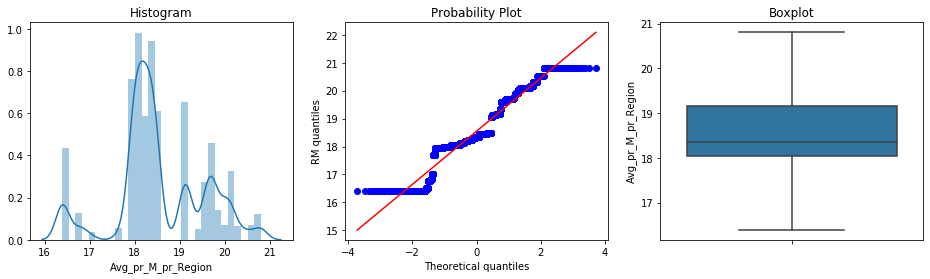

The feature is Avg_pr_M_pr_Vendor:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

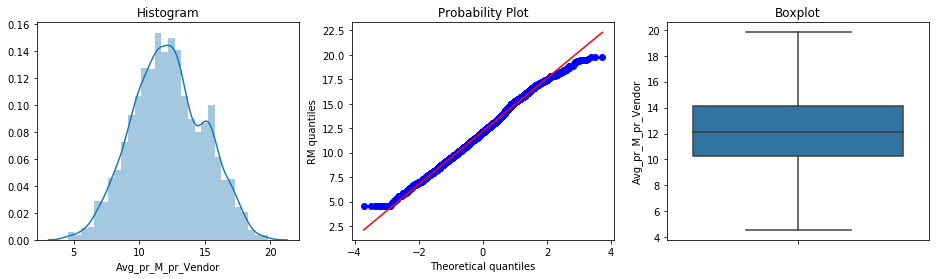

In [636]:
for column in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor']:
    print('The feature is {}:'.format(column))
    diagnostic_plots(data_tf1_ROut, column)

### Final Model Pipeline

#### Summary:

1. Read the data fresh from input file. 
2. Creating additional features.
3. Before Train Test split perform below steps:
    1. Variable Transformation Using Box Cox Method.
4. Perform Train-Test Split
5. Steps after Train-Test Split:
    1. Discretization. The features to be included are followed by ordinal encoding:
        1. Scaled_Country
        2. Scaled_Tower
    2. Rare Label Encoding on below features:
        1. Region
        2. Country
        3. Tower
        4. Category
    3. Perform Frequency Encoding on above variables.
    4. Outlier Treatment using winsorization on below variables:
        1. Avg_pr_M
        2. Avg_pr_M_pr_Tower
        3. Avg_pr_M_pr_Category
        4. Avg_pr_M_pr_Country
        5. Avg_pr_M_pr_Region
        6. Avg_pr_M_pr_Vendor
6. Model Building 
        1. Building end-to-end pipeline which include both hyper parameter tunning for prediction algorithm & selecting best parameter for Feature Engineering.

#### Reading Data & Creating New Features

In [15]:
df.head(4)

Supplier Name    Region Country    Tower  \
Final_Date                                                         
2019-01              AptarGroup, Inc.      APAC   China      R&D   
2019-01            UnitedHealth Group      APAC   India       IT   
2019-01            UnitedHealth Group  Americas     USA       IT   
2019-01     Ferrellgas Partners, L.P.      APAC   China  TechOps   

                                               Category          Spend  \
Final_Date                                                               
2019-01         Laboratory Equipment Services and Parts  964537.590650   
2019-01                                     IT Hardware    1609.153631   
2019-01                                     IT Hardware    1210.518148   
2019-01     Maintenance Repair Operation (MRO) Services  158519.945582   

                 Avg_pr_M  Avg_pr_M_pr_Tower  Avg_pr_M_pr_Category  \
Final_Date                                                           
2019-01     109290.666602       76869.416233         119281.653576   
2019-01     109290.666602       38833.989011           1886.232363   
2019-01     109290.666602       38833.989011           1886.232363   
2019-01     109290.666602      165618.041715          82273.225450   

            Avg_pr_M_pr_Country  Avg_pr_M_pr_Region  Avg_pr_M_pr_Vendor  \
Final_Date                                                                
2019-01           121275.831388       113822.506881       964537.590650   
2019-01            34003.078873       113822.506881         1409.835890   
2019-01           117454.202293       121915.769437         1409.835890   
2019-01           121275.831388       113822.506881        87954.545461   

            Scaled_Tower  Scaled_Catagory  Scaled_Country  Scaled_Region  \
Final_Date                                                                 
2019-01         0.703348         1.091417        1.109663       1.041466   
2019-01         0.355328         0.017259        0.311125       1.041466   
2019-01         0.355328         0.017259        1.074696       1.115519   
2019-01         1.515391         0.752793        1.109663       1.041466   

            Scaled_Vendor  
Final_Date                 
2019-01          8.825434  
2019-01          0.012900  
2019-01          0.012900  
2019-01          0.804776

#### Variable Transformation Using box cox/YeoJohnsonTransformer

In [296]:
sample = pd.read_excel('sample2.xlsx', date_parser=True)
sample.drop(['Final_Date', 'Supplier Name'], axis=1, inplace = True)
sample['Spend'] = 0
sample.head(2)

<IPython.core.display.Javascript object>

Region Country Tower                            Category       Avg_pr_M  \
0  Americas  Mexico    IT  IT Software Licenses & Maintenance  170756.493094   
1  Americas  Mexico  REFS       Office Equipment and Supplies  170756.493094   

   Avg_pr_M_pr_Tower  Avg_pr_M_pr_Category  Avg_pr_M_pr_Country  \
0       40692.051166          21050.560433        295151.662955   
1      319462.504989          19472.084934        295151.662955   

   Avg_pr_M_pr_Region  Avg_pr_M_pr_Vendor  Scaled_Tower  Scaled_Country  Spend  
0       394262.545137         4690.751388      0.238305        1.728495      0  
1       394262.545137         4690.751388      1.870866        1.728495      0

In [184]:
lt1 = vt.BoxCoxTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                                        'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region',
                                        'Avg_pr_M_pr_Vendor'])
lt1.fit(df)
df = lt1.transform(df)
sample = lt1.transform(sample)

ValueError: Some variables contain negative values, try Yeo-Johnson transformation instead

In [297]:
lt2 = vt.YeoJohnsonTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                                            'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region',
                                            'Avg_pr_M_pr_Vendor'])
lt2.fit(df)
df_2 = lt2.transform(df)
sample = lt2.transform(sample)

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\stats\morestats.py:1478: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1987: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1984: RuntimeWarning: inval

In [269]:
df_2.head(2)

Region Country Tower                                 Category  \
Final_Date                                                                 
2019-01      APAC   China   R&D  Laboratory Equipment Services and Parts   
2019-01      APAC   India    IT                              IT Hardware   

                    Spend  Avg_pr_M  Avg_pr_M_pr_Tower  Avg_pr_M_pr_Category  \
Final_Date                                                                     
2019-01     964537.590650  0.167208         183.230944             16.604240   
2019-01       1609.153631  0.167208         140.950243              9.420613   

            Avg_pr_M_pr_Country  Avg_pr_M_pr_Region  Avg_pr_M_pr_Vendor  \
Final_Date                                                                
2019-01              148.486562           17.989152           16.826462   
2019-01               95.870759           17.989152            8.043436   

            Scaled_Tower  Scaled_Country  
Final_Date                                
2019-01         0.703348        1.109663  
2019-01         0.355328        0.311125

#### Train Test Split

In [298]:
X_train, X_test, y_train, y_test = train_test_split(
    df_2.drop(['Spend'],axis=1),  # predictors
    df_2['Spend'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((5620, 12), (1405, 12))

#### GridSearch Pipeline for best Feature Engineering & Model selection and Prediction

###### Lasso

In [83]:
DEF_pipe = Pipeline([

    # discretization & ordinal encoding
    ('discrit',
     EqualFrequencyDiscretiser(q=10, variables=['Scaled_Tower','Scaled_Country'], return_object = True)),
     
    ('ord_enc',
     OrdinalCategoricalEncoder(encoding_method = 'arbitrary', variables=['Scaled_Tower','Scaled_Country'])),

    # Rare Label Encoding and Catagorical(frequency) Encoding
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(n_categories=4, variables=['Region','Country','Tower','Category'], replace_with='Rare')),
    
    ('categorical_encoder',
     CountFrequencyCategoricalEncoder(encoding_method='count', variables=['Region','Country','Tower','Category'])),
     
    # Outlier Treatment
    ('winsorization',
     Winsorizer(distribution='skewed', tail='both', fold=1.5,
                variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                           'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])),

    # Algorithm
    ('reg', Lasso())
     
])

In [84]:
param_grid = {
    # trying different feature engineering parameters
    'discrit__q':  [10, 15],
    'encoder_rare_label__tol': [0.02, 0.04, 0.05],
    
    # trying different gradient boosted tree model paramenters
    'reg__alpha': [0.1,0.3,0.5,0.8,1]
}

In [85]:
grid_search = GridSearchCV(DEF_pipe, param_grid, cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)
print(("best r2 from grid search: %.3f" % grid_search.score(X_train, y_train)))

grid_search.best_estimator_

best r2 from grid search: 0.216


C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\feature_engine\categorical_encoders.py:719: UserWarning: The number of unique categories for variable Region is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))


Pipeline(steps=[('discrit',
                 EqualFrequencyDiscretiser(return_object=True,
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('ord_enc',
                 OrdinalCategoricalEncoder(encoding_method='arbitrary',
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(n_categories=4,
                                             variables=['Region', 'Country',
                                                        'Tower', 'Category'])),
                ('categorical_encoder',
                 CountFrequencyCategoricalEncoder(variables=['Region',
                                                             'Country', 'Tower',
                                                             'Category

###### Gradient boosting

In [112]:
DEF_pipe = Pipeline([

    # discretization & ordinal encoding
    ('discrit',
     EqualFrequencyDiscretiser(q=10, variables=['Scaled_Tower','Scaled_Country'], return_object = True)),
     
    ('ord_enc',
     OrdinalCategoricalEncoder(encoding_method = 'arbitrary', variables=['Scaled_Tower','Scaled_Country'])),

    # Rare Label Encoding and Catagorical(frequency) Encoding
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(n_categories=4, variables=['Region','Country','Tower','Category'], replace_with='Rare')),
    
    ('categorical_encoder',
     CountFrequencyCategoricalEncoder(encoding_method='count', variables=['Region','Country','Tower','Category'])),
     
    # Outlier Treatment
    ('winsorization',
     Winsorizer(distribution='skewed', tail='both', fold=1.5,
                variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                           'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])),

    # Algorithm
    ('gbm', GradientBoostingRegressor(learning_rate=0.01, random_state=10))
     
])

In [113]:
param_grid = {
    # trying different feature engineering parameters
    'discrit__q':  [10, 15],
    'encoder_rare_label__tol': [0.02, 0.04, 0.05],
    
    # trying different gradient boosted tree model paramenters
    'gbm__learning_rate': [0.1,0.5], 'gbm__n_estimators': [200,400,500]
}

In [114]:
grid_search = GridSearchCV(DEF_pipe, param_grid, cv=5, n_jobs=-1, scoring='r2')

In [115]:
grid_search.fit(X_train, y_train)

# we print the best score over the train set
print(("best r2 from grid search: %.3f" % grid_search.score(X_train, y_train)))

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\feature_engine\categorical_encoders.py:719: UserWarning: The number of unique categories for variable Region is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))


best r2 from grid search: 0.905


In [66]:
# we can print the best estimator parameters like this
grid_search.best_estimator_

Pipeline(steps=[('discrit',
                 EqualFrequencyDiscretiser(return_object=True,
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('ord_enc',
                 OrdinalCategoricalEncoder(encoding_method='arbitrary',
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(n_categories=4, tol=0.02,
                                             variables=['Region', 'Country',
                                                        'Tower', 'Category...
                 CountFrequencyCategoricalEncoder(variables=['Region',
                                                             'Country', 'Tower',
                                                             'Category'])),
                ('winsoriz

In [116]:
prediction(X_train, X_test)

train mse: 38854316867.638245
train rmse: 197114.9838739771
train r2: 0.9047629754486272

test mse: 116488325837.78592
test rmse: 341303.8614457591
test r2: 0.5876733699966417


###### Random Forest

In [108]:
DEF_pipe = Pipeline([

    # discretization & ordinal encoding
    ('discrit',
     EqualFrequencyDiscretiser(q=10, variables=['Scaled_Tower','Scaled_Country'], return_object = True)),
     
    ('ord_enc',
     OrdinalCategoricalEncoder(encoding_method = 'arbitrary', variables=['Scaled_Tower','Scaled_Country'])),

    # Rare Label Encoding and Catagorical(frequency) Encoding
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(n_categories=4, variables=['Region','Country','Tower','Category'], replace_with='Rare')),
    
    ('categorical_encoder',
     CountFrequencyCategoricalEncoder(encoding_method='count', variables=['Region','Country','Tower','Category'])),
     
    # Outlier Treatment
    ('winsorization',
     Winsorizer(distribution='skewed', tail='both', fold=1.5,
                variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                           'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])),

    # Algorithm
    ('reg', RandomForestRegressor())
     
])

In [109]:
param_grid = {
    # trying different feature engineering parameters
    'discrit__q':  [10, 15],
    'encoder_rare_label__tol': [0.02, 0.04, 0.05],
    
    # trying different gradient boosted tree model paramenters
    'reg__n_estimators': [100,200,400,500], 'reg__random_state': [10]
}

In [110]:
grid_search = GridSearchCV(DEF_pipe, param_grid, cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)
print(("best r2 from grid search: %.3f" % grid_search.score(X_train, y_train)))

grid_search.best_estimator_

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\feature_engine\categorical_encoders.py:719: UserWarning: The number of unique categories for variable Region is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))


best r2 from grid search: 0.946


Pipeline(steps=[('discrit',
                 EqualFrequencyDiscretiser(return_object=True,
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('ord_enc',
                 OrdinalCategoricalEncoder(encoding_method='arbitrary',
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(n_categories=4, tol=0.02,
                                             variables=['Region', 'Country',
                                                        'Tower', 'Category...
                ('categorical_encoder',
                 CountFrequencyCategoricalEncoder(variables=['Region',
                                                             'Country', 'Tower',
                                                             '

In [111]:
prediction(X_train, X_test)

train mse: 21980974262.32511
train rmse: 148259.82012104665
train r2: 0.9461217503163015

test mse: 111069597770.27873
test rmse: 333271.0575046665
test r2: 0.6068537116052177


###### eXtreme Gradient Boosting

In [90]:
DEF_pipe = Pipeline([

    # discretization & ordinal encoding
    ('discrit',
     EqualFrequencyDiscretiser(q=10, variables=['Scaled_Tower','Scaled_Country'], return_object = True)),
     
    ('ord_enc',
     OrdinalCategoricalEncoder(encoding_method = 'arbitrary', variables=['Scaled_Tower','Scaled_Country'])),

    # Rare Label Encoding and Catagorical(frequency) Encoding
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(n_categories=4, variables=['Region','Country','Tower','Category'], replace_with='Rare')),
    
    ('categorical_encoder',
     CountFrequencyCategoricalEncoder(encoding_method='count', variables=['Region','Country','Tower','Category'])),
     
    # Outlier Treatment
    ('winsorization',
     Winsorizer(distribution='skewed', tail='both', fold=1.5,
                variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                           'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])),

    # Algorithm
    ('reg',  XGBRegressor())
     
])

In [91]:
param_grid = {
    # trying different feature engineering parameters
    'discrit__q':  [10, 15],
    'encoder_rare_label__tol': [0.02, 0.04, 0.05],
    
    # trying different gradient boosted tree model paramenters
    'reg__n_estimators': [100,200,400,500], 'reg__random_state': [10], 'reg__learning_rate': [0.01,0.1,0.5,1],
    'reg__n_gamma': [0,0.1]
}

In [92]:
grid_search = GridSearchCV(DEF_pipe, param_grid, cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)
print(("best r2 from grid search: %.3f" % grid_search.score(X_train, y_train)))

grid_search.best_estimator_

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\feature_engine\categorical_encoders.py:719: UserWarning: The number of unique categories for variable Region is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))


[12:38:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best r2 from grid search: 0.817


Pipeline(steps=[('discrit',
                 EqualFrequencyDiscretiser(q=15, return_object=True,
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('ord_enc',
                 OrdinalCategoricalEncoder(encoding_method='arbitrary',
                                           variables=['Scaled_Tower',
                                                      'Scaled_Country'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(n_categories=4, tol=0.02,
                                             variables=['Region', 'Country',
                                                        'Tower', 'Cat...
                 CountFrequencyCategoricalEncoder(variables=['Region',
                                                             'Country', 'Tower',
                                                             'Category'])),
                ('winsori

In [107]:
prediction(X_train, X_test)

train mse: 74826241084.24153
train rmse: 273543.85587002593
train r2: 0.8165910731746184

test mse: 108295411583.56265
test rmse: 329082.68198670476
test r2: 0.6166733294351057


###### Function for Prediction & Score

In [106]:
def prediction(X_train, X_test):
    # Prediction Using GridSearch to make use of Cross Validation Approach
    X_train_preds = grid_search.predict(X_train)
    X_test_preds = grid_search.predict(X_test)
    
    print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
    print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
    print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
    print()
    print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
    print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
    print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

#### Without Pipeline in case we don't want to use GridSearchCV prediction feature (Not Useful)

In [299]:
sample.drop(['Spend'], axis=1, inplace=True)

In [300]:
disc = EqualFrequencyDiscretiser(q=15, variables=['Scaled_Tower','Scaled_Country'], return_object = True)

# find the intervals
disc.fit(X_train)

# transform train and text
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)
sample_t = disc.transform(sample)

In [301]:
ce = OrdinalCategoricalEncoder(encoding_method = 'ordered', variables=['Scaled_Tower','Scaled_Country'])

ce.fit(train_t, y_train)

# transform train and text
train_t = ce.transform(train_t)
test_t = ce.transform(test_t)
sample_t = ce.transform(sample_t)

In [290]:
rar = RareLabelCategoricalEncoder(tol=0.02, n_categories=4, variables=['Region','Country','Tower','Category'], replace_with='Rare')

rar.fit(train_t)

# transform train and text
train_t = rar.transform(train_t)
test_t = rar.transform(test_t)
sample_t = rar.transform(sample_t)

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\feature_engine\categorical_encoders.py:719: UserWarning: The number of unique categories for variable Region is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))


In [247]:
'''fre = CountFrequencyCategoricalEncoder(encoding_method='count', variables=['Region','Country','Tower','Category'])

fre.fit(train_t)

# transform train and text
train_t = fre.transform(train_t)
test_t = fre.transform(test_t)'''

"fre = CountFrequencyCategoricalEncoder(encoding_method='count', variables=['Region','Country','Tower','Category'])\n\nfre.fit(train_t)\n\n# transform train and text\ntrain_t = fre.transform(train_t)\ntest_t = fre.transform(test_t)"

OR

In [302]:
ordinal_enc = OrdinalCategoricalEncoder(encoding_method='arbitrary',
                                        variables=['Region','Country','Tower','Category'])
ordinal_enc.fit(train_t)

# transform train and text
train_t = ordinal_enc.transform(train_t)
test_t = ordinal_enc.transform(test_t)
sample_t = ordinal_enc.transform(sample_t)

In [303]:
win = Winsorizer(distribution='skewed', tail='both', fold=1.5,
                 variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                           'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])

win.fit(train_t)

# transform train and text
train_t = win.transform(train_t)
test_t = win.transform(test_t)
sample_t = win.transform(sample_t)

In [304]:
model = XGBRegressor(random_state=10, n_estimators=500)

model.fit(train_t, y_train)

X_train_preds = model.predict(train_t)
X_test_preds = model.predict(test_t)
sample_preds = model.predict(sample_t)

[15:03:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [151]:
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 128023793182.1982
train rmse: 357804.1268378527
train r2: 0.6861968986357831

test mse: 160686729708.39865
test rmse: 400857.49301765417
test r2: 0.43122697257073184


In [306]:
sample['Spend'] = sample_preds
sample.to_excel('forecasting.xlsx')

#### Residual Study

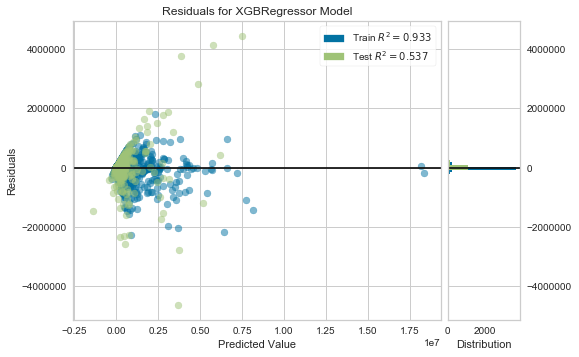

In [101]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model, test_alpha=0.50, train_alpha=0.5)

visualizer.fit(train_t, y_train)  # Fit the training data to the visualizer
visualizer.score(test_t, y_test)  # Evaluate the model on the test data
visualizer.show() 

#### Select Base Model Using CV

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


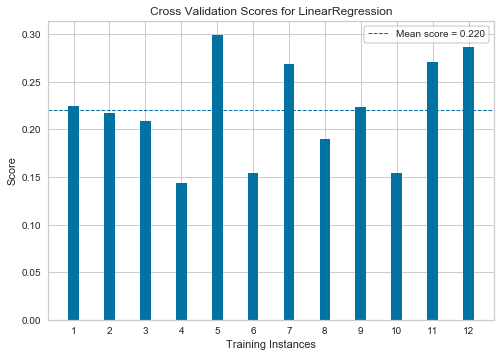

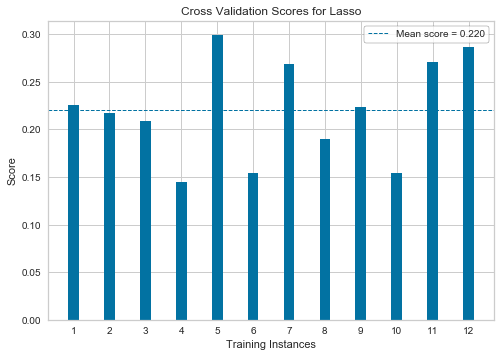

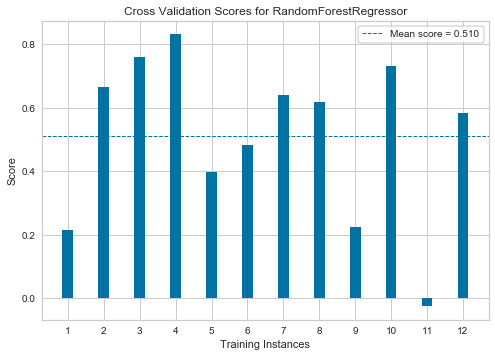

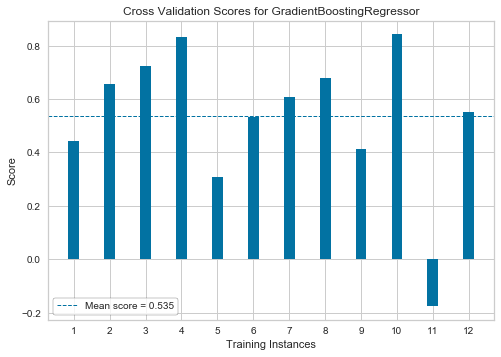

[08:32:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:30] WARNI

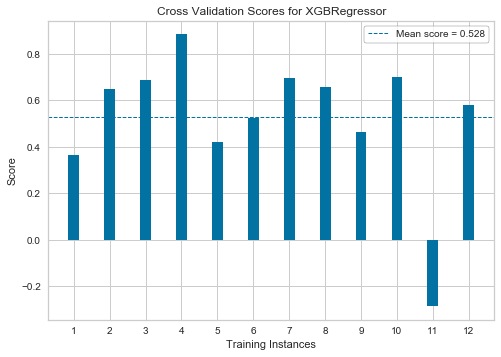

In [447]:
models = [LinearRegression(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()]

cv = KFold(n_splits=12, random_state=42)

scores = ['r2']
for model in models: 
    for score in scores:
        visualizer = cv_scores(model, train_t, y_train, cv=cv, scoring=score)

#### Learning Curve

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


[18:04:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:07] WARNI

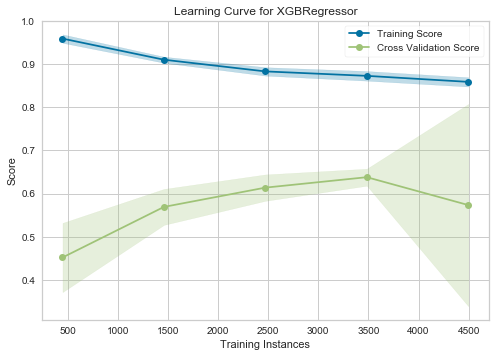

In [208]:
# XGBoostRegressor
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(train_t, y_train)        
visualizer.show()

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


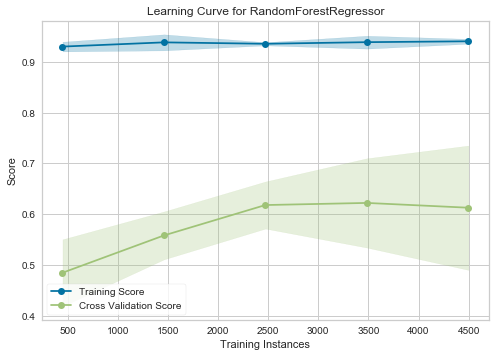

In [211]:
# RandomForest
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(train_t, y_train)        
visualizer.show()

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


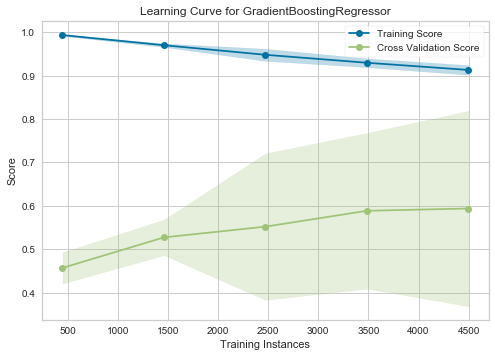

In [523]:
# Gradientboosting Regressor
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(train_t, y_train)        
visualizer.show()

### Time Series Analysis Continued:

#### Function to Extract Time Series Data from input file

In [335]:
# will return a category if all 17 month data is present
# we can build seperate models on each

def convert(col_name, cat, df_temp, Avg_Value_Column):
    date = np.array(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
                 '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
                 '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01'], dtype='datetime64[M]')
    idx = pd.DatetimeIndex(date)
    '''
    The parameters to be passed are:
    df_temp: Name of the data frame
    col_name: Column name
    cat: A class of the column for which we want a time series dataframe to be created.
    Avg_Value_Column: Average value of the class of any column per month. This is calculated while creatng data.
    '''
    df_temp = df[df[col_name]==cat].groupby('Final_Date')[Avg_Value_Column].mean().to_frame()
    df_temp['Date'] = idx
    df_temp.set_index('Date',inplace=True)
    if(len(df_temp) == 17):
        print('Length is {}'.format(len(df_temp)))
        return df_temp
    else:
        print('Not enough data for {}:'.format(cat))

#### Region

###### Plot & data

<IPython.core.display.Javascript object>

Length is 17


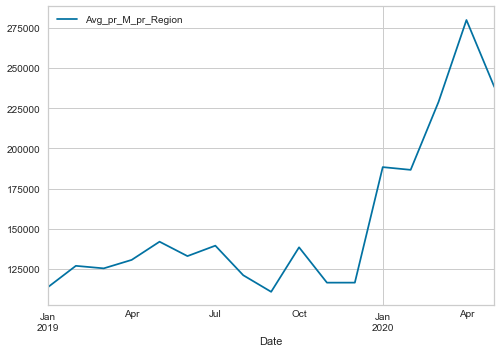

In [344]:
sample1 = convert('Region', 'APAC', df, 'Avg_pr_M_pr_Region')
#print(sample)
sample1.plot()

<IPython.core.display.Javascript object>

Length is 17


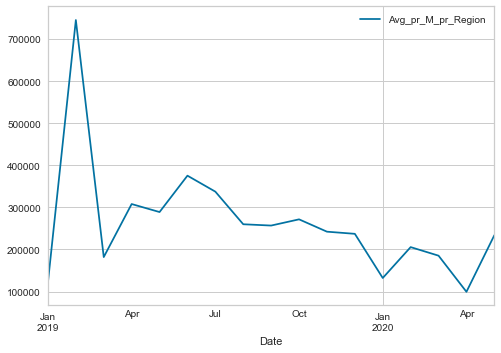

In [345]:
sample2 = convert('Region', 'Americas', df, 'Avg_pr_M_pr_Region')
#print(sample)
sample2.plot()

<IPython.core.display.Javascript object>

Length is 17


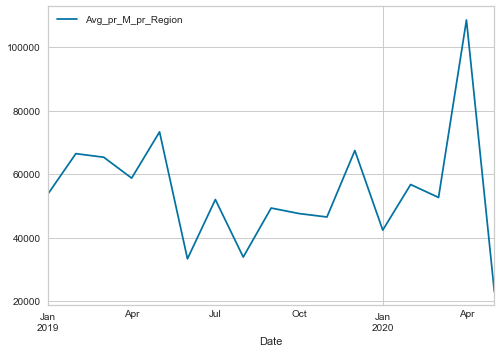

In [346]:
sample3 = convert('Region', 'Europe', df, 'Avg_pr_M_pr_Region')
#print(sample)
sample3.plot()

### Exploring the possibility of Panel Data

In [126]:
df = pd.read_excel('final2.xlsx', parse_dates=True)

<IPython.core.display.Javascript object>

In [127]:
rar = RareLabelCategoricalEncoder(tol=0.02, n_categories=4, variables=['Region','Country','Tower','Category'], 
                                  replace_with='Rare')

df = rar.fit_transform(df)

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\feature_engine\categorical_encoders.py:719: UserWarning: The number of unique categories for variable Region is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))


In [128]:
df_test = df.set_index(['Tower', 'Month'])

In [129]:
df_test[0:10]

Supplier Name    Region      Country  \
Tower      Month                                                                
R&D        2019-01-01                 AptarGroup, Inc.      APAC        China   
IT         2019-01-01               UnitedHealth Group      APAC        India   
           2019-01-01               UnitedHealth Group  Americas          USA   
TechOps    2019-01-01        Ferrellgas Partners, L.P.      APAC        China   
           2019-01-01        Ferrellgas Partners, L.P.      APAC        China   
Commercial 2019-01-01                    Equinix, Inc.    Europe  Switzerland   
REFS       2019-01-01    Wyndham Worldwide Corporation      APAC        China   
           2019-01-01                    Hologic, Inc.      APAC        China   
Commercial 2019-01-01  Nationwide Mutual Insurance Co.      APAC        China   
TechOps    2019-01-01                          MetLife      APAC        China   

                                                          Category  \
Tower      Month                                                     
R&D        2019-01-01      Laboratory Equipment Services and Parts   
IT         2019-01-01                                         Rare   
           2019-01-01                                         Rare   
TechOps    2019-01-01  Maintenance Repair Operation (MRO) Services   
           2019-01-01    MRO Components / Integrator / Distributor   
Commercial 2019-01-01                            Internal Meetings   
REFS       2019-01-01                Office Equipment and Supplies   
           2019-01-01                        Facilities Management   
Commercial 2019-01-01                            Internal Meetings   
TechOps    2019-01-01  Maintenance Repair Operation (MRO) Services   

                               Spend  
Tower      Month                      
R&D        2019-01-01  964537.590650  
IT         2019-01-01    1609.153631  
           2019-01-01    1210.518148  
TechOps    2019-01-01  158519.945582  
           2019-01-01   17389.145339  
Commercial 2019-01-01    3299.926800  
REFS       2019-01-01    1729.330032  
           2019-01-01    5500.178387  
Commercial 2019-01-01  108370.018355  
TechOps    2019-01-01   24008.567029